In [1]:
require 'nn'
require 'image' --necessary?
require("lfwMCMCUpdatesFunction")
require("lfwCDBNModelBuilderFunction")
-- spatialConvolution only seems to be able to process one image ata ie (i.e. expects a 3D tensor only)

In [ ]:
--gradFilterConv.weight[{{},{1},{},{}}] = hiddenTensor --!!!!!!CHANGED!!!!!! 

In [2]:
function CDBNLayerTrainer(model,index,visLayer,convergenceThreshold,learningRate,sparsityPenalty)
    --Need to check dimensions of input
    --How do we train with more than one image??? I think since the energy function has been logged we can
    --  simply add the differential approximations that each of the images gives us separately to obtain the 
    --  final gradient approximation. The function as it stands may not work with this - some tweaking will
    --  need to take place (dimensions and indices being off-kilter etc.) However, continue with the one 
    --  image case, test and then see if we can generalise.
    --  Of course, because we assume independence given the hidden nodes so the density function is a simple
    --  multiplication, which means the log likelihood is a simple addition wrt all of the separate images.
    --spatialConvolution can't do more than one image at a time; do different processing for multi-image
    
    --repeating over the training data; could just randomly pick one image to update the filter weights for each
    --  iteration.
    
    --convergenceThreshold is like an epsilon of closeness
    --only index == 1 will have a Real visible layer, others all will have a Binary visible Layer.
    
    --visLayer; first dimension for number input planes, second and third for others.
    
    --variable setup---
    convergenceFlag = 0
    repeatCounter = 0
    --predeclaring the memory to be used.
    --hiddenTensor = torch.Tensor(model:get(index).output:size())
    hiddenTensor = model:get(index):forward(visLayer)
    origHiddenTensorClone = hiddenTensor:clone()
    probTensor = torch.Tensor(hiddenTensor:size())
    --so that we don't interfere with memory outside of the function we will create a clone of the visLayer
    visLayerClone = torch.Tensor(visLayer:size())
    visBias = torch.Tensor(model:get(index).bias:size())
    --Nh,K,Vl,Nw,Nv,visBias
    K = hiddenTensor:size()[1]
    Vl = visLayer:size()[1]
    Nh = hiddenTensor:size()[2]
    Nv = visLayer:size()[2]
    Nw = model:get(index).weight:size()[3]
    --/variable setup---
    
    --INITIALISATION STEP. --Here we will need to initialise the filters using the K-Means/Gaussian EM thing.
    filterWeights = model:get(index).weight
    hiddenBias = model:get(index).bias --Note that these create a reference, not a clone, so altering
        --either filterWeights or hiddenBias will also alter the model's parameters too.
    --/INITIALISATION STEP.
    
    --PRECALLING OF FUNCTIONS---
    --gradFilterConv will be used in the parameter updates step, specifically to update the filters. Since
    --  the weight is tied to the hiddenTensor and NOT CLONED we should be able to update the convolution
    --  without having to constantly redeclare the convolution
    gradFilterConv = nn.SpatialConvolution(1,K,Nh,Nh)
    gradFilterConv.bias = torch.Tensor(K):fill(0)
    gradFilterConv.weight[1] = hiddenTensor
    
    --origSampleFilterWeightDifferential used as the base from which the filter weights CD gradient is 
    --    approximated
    origSampleFilterWeightDifferential = torch.Tensor(Vl,K,Nw,Nw) 
    for l = 1,Vl do
        origSampleFilterWeightDifferential[l] = gradFilterConv:forward(visLayer[l])[1] --???? Hope this works
    end
    --/PRECALLING OF FUNCTIONS---
    
    while (repeatCounter < 10000 or convergenceFlag == 0) do
        repeatCounter = repeatCounter + 1
        
        --*********************************************************************
        --switch visible image being considered -- REJIG HIDDEN TENSOR STUFF.
        --*********************************************************************
        
        --MCMC UPDATES STEP - can expand this for CD-k, but for the moment just using CD-1
        --gibbsHiddenUpdate
        hiddenTensor = origHiddenTensorClone:clone()
        gibbsHiddenUpdate(Nh,K,Vl,Nw,hiddenTensor,probTensor)

        if index == 1 then
            -- Real Visible Layer 
            gibbsRealVisibleUpdate(model,index,Nv,K,Vl,Nw,visBias,visLayerClone,hiddenTensor)
        
        else 
            -- Binary Visible Layer
            gibbsBinaryVisibleUpdate(model,index,Nv,K,Vl,Nw,visBias,visLayerClone,hiddenTensor)
            
        end
        --/MCMC UPDATES STEP.
        
        --Update weights and biases using the CD approximation---
        --learningRate will pop up here
        
        fWCopy = filterWeights:clone()
        hBCopy = hiddenBias:clone()
        vBCopy = visBias:clone()

        --filter weight updates
        newSampleFWDiff = torch.Tensor(Vl,K,Nw,Nw)
        for l = 1,Vl do 
          newSampleFWDiff[l] = gradFilterConv:forward(visLayer[l])[1]
        end
        filterWeights:add(learningRate/(Nh*Nh), origSampleFilterWeightDifferential:add(-1,newSampleFWDiff)) 
        
        --hidden Bias Updates
        --  Without Sparsity
        --hiddenBias:add(learningRate,origHiddenTensorClone:sum(2):sum(3):add(-1,origHiddenTensorClone:sum(2):sum(3)))
        --  With Sparsity
        hiddenBias:add(learningRate/(Nh*Nh),origHiddenTensorClone:sum(2):sum(3):add(-1,origHiddenTensorClone:sum(2):sum(3)))
        
        --uses the probTensor in 
        sparsityPenaltyAddition = torch.Tensor(K):fill(sparsityPenalty):add(-1/(Nh*Nh),probTensor:sum(2):sum(3))        
        hiddenBias:add(learningRate,sparsityPenaltyAddition)
        
        --visible Bias Updates
        visBias:add(learningRate,  visLayer:sum(2):sum(3):add(-1,visLayerClone:sum(2):sum(3))   )
        
        --/Update weights and biases using the CD approximation---
        
        if(torch.dist(visBias,vBCopy)+torch.dist(hiddenBias,hBCopy)+torch.dist(fWCopy,filterWeights) < convergenceThreshold ) then 
            convergenceFlag = 1
        end
        --calculate convergenceDistance and see whether to terminate process or keep going.
    end
    
    --At this point the weights and hiddenBias and visBias should have been learned.
    
end

In [105]:
model = CDBNModelBuilder(2,{3,3},{32,6},{10,10})

In [4]:
testReadFile = torch.DiskFile('lfwDataSetShort.foo', 'r')
testRead = testReadFile:readObject()

In [53]:
trainingData = image.scale(testRead[{{1,20},{},{}}],100,100)
--collectgarbage("count")

In [51]:
--collectgarbage("count")

1575.8134765625	


In [97]:
trainingData:size()


  20
 100
 100
[torch.LongStorage of size 3]



In [55]:
itorch.image(trainingData)

In [106]:
index = 1
visLayer = trainingData[{{1},{},{}}]

In [107]:
--function CDBNLayerTrainer(model,index,visLayer,convergenceThreshold,learningRate,sparsityPenalty)


    --variable setup---
    convergenceFlag = 0
    repeatCounter = 0

In [108]:

    --predeclaring the memory to be used.
    --hiddenTensor = torch.Tensor(model:get(index).output:size())
    hiddenTensor = model:get(index):forward(visLayer)
    origHiddenTensorClone = hiddenTensor:clone()
    probTensor = torch.Tensor(hiddenTensor:size())

In [109]:

    --so that we don't interfere with memory outside of the function we will create a clone of the visLayer
    visLayerClone = torch.Tensor(visLayer:size())
    
    --Nh,K,Vl,Nw,Nv,visBias
    K = hiddenTensor:size()[1]
    Vl = visLayer:size()[1]
visBias = torch.Tensor(Vl):fill(0)
    Nh = hiddenTensor:size()[2]
    Nv = visLayer:size()[2]
    Nw = model:get(index).weight:size()[3]

In [110]:

    --/variable setup---
    
    --INITIALISATION STEP. --Here we will need to initialise the filters using the K-Means/Gaussian EM thing.
    filterWeights = model:get(index).weight
    hiddenBias = model:get(index).bias --Note that these create a reference, not a clone, so altering
        --either filterWeights or hiddenBias will also alter the model's parameters too.
    --/INITIALISATION STEP.
    
    --PRECALLING OF FUNCTIONS---
    --gradFilterConv will be used in the parameter updates step, specifically to update the filters. Since
    --  the weight is tied to the hiddenTensor and NOT CLONED we should be able to update the convolution
    --  without having to constantly redeclare the convolution
    gradFilterConv = nn.SpatialConvolution(1,K,Nh,Nh)

In [111]:
K

32	


In [112]:

    gradFilterConv.weight[{{},{1},{},{}}] = hiddenTensor --!!!!!!CHANGED!!!!!! annoyingly it's nOutxnInxkWxkH
    gradFilterConv.bias = torch.Tensor(K):fill(0)

In [15]:
test = gradFilterConv:forward(visLayer)

In [16]:
hiddenTensor:size()


   4
 231
 231
[torch.LongStorage of size 3]



In [113]:
    gradFilterConv.weight[{{},{1},{},{}}] = hiddenTensor
    origSampleFilterWeightDifferential = torch.Tensor(Vl,K,Nw,Nw) 
    --origSampleFilterWeightDifferential used as the base from which the filter weights CD gradient is 
    --    approximated; the summation convolution with the original training data sample
    for l = 1,Vl do
        origSampleFilterWeightDifferential[l] = gradFilterConv:forward(visLayer[{{l},{},{}}]) --???? Hope this works
    end
    --/PRECALLING OF FUNCTIONS---
    

In [18]:
        repeatCounter = repeatCounter + 1
        print(repeatCounter)
        --*********************************************************************
        --switch visible image being considered -- REJIG HIDDEN TENSOR STUFF.
        --*********************************************************************
        
        --MCMC UPDATES STEP - can expand this for CD-k, but for the moment just using CD-1
        --gibbsHiddenUpdate
        hiddenTensor = origHiddenTensorClone:clone()
        hiddenTensor, probTensor =  gibbsHiddenUpdate(Nh,K,Nw,hiddenTensor)


1	


In [23]:
--

In [57]:
--hiddenTensor[1]

In [24]:
     if index == 1 then
    --print("Real11")
            -- Real Visible Layer 
            visLayerClone = gibbsRealVisibleUpdate(model,index,Nv,K,Vl,Nw,visBias,hiddenTensor)
        
        else 
            -- Binary Visible Layer
            visLayerClone = gibbsBinaryVisibleUpdate(model,index,Nv,K,Vl,Nw,visBias,hiddenTensor)
            
    end

In [30]:
    visLayer:min()

0	


In [31]:

        --/MCMC UPDATES STEP.
        
        --Update weights and biases using the CD approximation---
        --learningRate will pop up here
        
        fWCopy = filterWeights:clone()
        hBCopy = hiddenBias:clone()
        vBCopy = visBias:clone()


In [32]:
--DEFINITELY WON'T WORK
        --filter weight updates
        newSampleFWDiff = torch.Tensor(Vl,K,Nw,Nw)
    --origSampleFilterWeightDifferential used as the base from which the filter weights CD gradient is 
    --    approximated; the summation convolution with the original training data sample
    --for l = 1,Vl do
      --  origSampleFilterWeightDifferential[l] = gradFilterConv:forward(visLayer[{{l},{},{}}]) --???? Hope this works
    --end
        for l = 1,Vl do 
          newSampleFWDiff[l] = gradFilterConv:forward(visLayerClone[{{l},{},{}}]) 
        end

In [39]:
learningRate = 0.05
sparsityPenalty=0.5
convergenceThreshold = 0.1

In [34]:

        filterWeights:add(learningRate/(Nh*Nh), origSampleFilterWeightDifferential:add(-1,newSampleFWDiff)) 
   
        --hidden Bias Updates
        --  Without Sparsity
        --hiddenBias:add(learningRate,origHiddenTensorClone:sum(2):sum(3):add(-1,origHiddenTensorClone:sum(2):sum(3)))
        --  With Sparsity
        hiddenBias:add(learningRate/(Nh*Nh),origHiddenTensorClone:sum(2):sum(3):add(-1,origHiddenTensorClone:sum(2):sum(3)))
             

In [35]:

        --uses the probTensor in 
        sparsityPenaltyAddition = torch.Tensor(K):fill(sparsityPenalty):add(-1/(Nh*Nh),probTensor:sum(2):sum(3))        
        hiddenBias:add(learningRate,sparsityPenaltyAddition)
        

In [36]:
visLayerClone:sum(2):sum(3)

(1,.,.) = 
  176.1287
[torch.DoubleTensor of size 1x1x1]



In [37]:

        --visible Bias Updates
        visBias:add(learningRate,  visLayer:sum(2):sum(3):add(-1,visLayerClone:sum(2):sum(3))   )
        

 805.6251
[torch.DoubleTensor of size 1]



In [40]:

        --/Update weights and biases using the CD approximation---
        
        if(torch.dist(visBias,vBCopy)+torch.dist(hiddenBias,hBCopy)+torch.dist(fWCopy,filterWeights) < convergenceThreshold ) then 
            convergenceFlag = 1
        end

In [42]:
torch.dist(visBias,vBCopy)+torch.dist(hiddenBias,hBCopy)+torch.dist(fWCopy,filterWeights)

805.71748008444	


In [114]:
repeatCounter =0
convergenceFlag = 0

In [116]:
learningRate = {0.0001,0.008,0.008}
sparsityPenalty=0.0625
convergenceThreshold = 0.001

In [117]:
while (repeatCounter < 1000 and convergenceFlag == 0) do
        repeatCounter = repeatCounter + 1
        print(repeatCounter)
        --*********************************************************************
        --switch visible image being considered -- REJIG HIDDEN TENSOR STUFF.
        --*********************************************************************
        
        --MCMC UPDATES STEP - can expand this for CD-k, but for the moment just using CD-1
        --gibbsHiddenUpdate
        hiddenTensor = origHiddenTensorClone:clone()
        hiddenTensor, probTensor =  gibbsHiddenUpdate(Nh,K,Nw,hiddenTensor)

        if index == 1 then
            -- Real Visible Layer 
            visLayerClone = gibbsRealVisibleUpdate(model,index,Nv,K,Vl,Nw,visBias,hiddenTensor)
        
        else 
            -- Binary Visible Layer
            visLayerClone = gibbsBinaryVisibleUpdate(model,index,Nv,K,Vl,Nw,visBias,hiddenTensor)
            
        end
        --/MCMC UPDATES STEP.
        
        --Update weights and biases using the CD approximation---
        --learningRate will pop up here
        
        fWCopy = filterWeights:clone()
        hBCopy = hiddenBias:clone()
        vBCopy = visBias:clone()

        --filter weight updates
        newSampleFWDiff = torch.Tensor(Vl,K,Nw,Nw)
        for l = 1,Vl do 
          newSampleFWDiff[l] = gradFilterConv:forward(visLayerClone[{{l},{},{}}]) 
        end
        filterWeights:add(learningRate[1]/(Nh*Nh),origSampleFilterWeightDifferential:add(-1,newSampleFWDiff)) 
        
        --hidden Bias Updates
        --  Without Sparsity
        --hiddenBias:add(learningRate,origHiddenTensorClone:sum(2):sum(3):add(-1,origHiddenTensorClone:sum(2):sum(3)))
        --  With Sparsity
        hiddenBias:add(learningRate[2]/(Nh*Nh),origHiddenTensorClone:sum(2):sum(3):add(-1,origHiddenTensorClone:sum(2):sum(3)))
        
        --uses the probTensor in 
        sparsityPenaltyAddition = torch.Tensor(K):fill(sparsityPenalty):add(-1/(Nh*Nh),probTensor:sum(2):sum(3))        
        hiddenBias:add(learningRate[2],sparsityPenaltyAddition)
        
        --visible Bias Updates
        visBias:add(learningRate[3]/(Nv*Nv),  visLayer:sum(2):sum(3):add(-1,visLayerClone:sum(2):sum(3))   )
        
        --/Update weights and biases using the CD approximation---
        
        if(torch.dist(visBias,vBCopy)+torch.dist(hiddenBias,hBCopy)+torch.dist(fWCopy,filterWeights) < convergenceThreshold ) then 
            convergenceFlag = 1
        end
    print(torch.dist(visBias,vBCopy))
    print(torch.dist(hiddenBias,hBCopy))
    print(torch.dist(fWCopy,filterWeights))
        --calculate convergenceDistance and see whether to terminate process or keep going.
    print(collectgarbage("count") .." KiloBytes used" )
    end

1	


0.0022578745962123	
0.0022985131111942	
0.00041289963019727	
2698.9736328125 KiloBytes used	
2	


0.0022958446406129	
0.0022985131111942	
0.00044326432343674	
1805.3720703125 KiloBytes used	
3	


0.0024193959572675	
0.0022985131111942	
0.00049004289186468	
3894.2548828125 KiloBytes used	
4	


0.0022185084374996	
0.0022985131111942	
0.00051339679612602	
2997.5283203125 KiloBytes used	
5	


0.002313865503209	
0.0022985131111942	
0.00053283516687078	
2222.4013671875 KiloBytes used	
6	


0.0020997543569927	
0.0022985131111942	
0.0005057635415674	
4305.0341796875 KiloBytes used	
7	


0.0023020408719167	
0.0022985131111942	
0.00053031557813369	
3399.6220703125 KiloBytes used	
8	


0.0021671921181727	
0.0022985131111942	
0.00054744962383523	
2500.1845703125 KiloBytes used	
9	


0.0019955972007151	
0.0022985131111942	
0.0005380840757771	
4125.6953125 KiloBytes used	
10	


0.0021921369728179	
0.0022985131111942	
0.0005762913466699	
3431.9638671875 KiloBytes used	
11	


0.0022056472291099	
0.0022985131111942	
0.00060985422158129	
2487.9658203125 KiloBytes used	
12	


0.0020866346598464	
0.0022985131111942	
0.00061543618460729	
3358.5283203125 KiloBytes used	
13	


0.0021802410269396	
0.0022985131111942	
0.00062727995272565	
3427.2470703125 KiloBytes used	
14	


0.0020170134779886	
0.0022985131111942	
0.00061415067266953	


2492.0595703125 KiloBytes used	
15	


0.0021529904390247	
0.0022985131111942	
0.00061978894222924	


3359.4970703125 KiloBytes used	
16	


0.0020154110370981	
0.0022985131111942	
0.00060528092438053	
3426.4970703125 KiloBytes used	
17	


0.0020925025051566	
0.0022985131111942	
0.00061060915519524	
2483.0908203125 KiloBytes used	
18	


0.0019297529216248	
0.0022985131111942	
0.00059988674466866	
3352.9970703125 KiloBytes used	
19	


0.002092265931	
0.0022985131111942	
0.0006032236837519	
3431.0498046875 KiloBytes used	
20	


0.0019680658213081	
0.0022985131111942	
0.00059191485771845	
2489.6220703125 KiloBytes used	
21	


0.0019683088487526	
0.0022985131111942	
0.0005687377487874	
3357.0263671875 KiloBytes used	
22	


0.0018028549003227	
0.0022985131111942	
0.00055054104997836	
3435.9658203125 KiloBytes used	
23	


0.0020217978293825	
0.0022985131111942	
0.00054075449383069	
2486.1220703125 KiloBytes used	
24	


0.0019788582692494	
0.0022985131111942	
0.00053389664063414	
3354.0283203125 KiloBytes used	
25	


0.0019359864780374	
0.0022985131111942	
0.00052457430156213	
3438.4970703125 KiloBytes used	
26	


0.0017201047524098	
0.0022985131111942	
0.00047916675987228	
2490.8408203125 KiloBytes used	
27	


0.0016643822246408	
0.0022985131111942	


0.00044539567271292	
3353.4033203125 KiloBytes used	
28	


0.00173934470271	
0.0022985131111942	
0.00041436705226642	
3437.3056640625 KiloBytes used	
29	


0.0017914104130384	
0.0022985131111942	
0.00039577998792903	
2492.0595703125 KiloBytes used	
30	


0.0015372600781328	
0.0022985131111942	
0.00034683564990715	
3362.2783203125 KiloBytes used	
31	


0.0017985356853828	
0.0022985131111942	
0.00031179105203108	
3430.4658203125 KiloBytes used	
32	


0.0017311811883331	


0.0022985131111942	
0.00027645621926659	
2488.2470703125 KiloBytes used	
33	


0.0016857045857884	
0.0022985131111942	
0.00023301717211567	
3358.5283203125 KiloBytes used	
34	


0.0015479523987893	
0.0022985131111942	
0.00016783824466161	
3427.2470703125 KiloBytes used	
35	


0.001770136656015	
0.0022985131111942	
0.00014554586179967	
2492.0576171875 KiloBytes used	
36	


0.001735089025358	
0.0022985131111942	
0.00012701718035324	
3359.4951171875 KiloBytes used	
37	


0.0017432699279838	
0.0022985131111942	
9.7809968848591e-05	
3426.4970703125 KiloBytes used	
38	


0.0016940013754987	
0.0022985131111942	
9.4448051375695e-05	
2483.0908203125 KiloBytes used	
39	


0.0016548108743472	
0.0022985131111942	
0.00010709363818887	
3352.9970703125 KiloBytes used	
40	


0.0016866850352133	
0.0022985131111942	
0.00012637194215587	
3431.0595703125 KiloBytes used	
41	


0.0015298716141347	
0.0022985131111942	
0.00016752238399877	
2490.6533203125 KiloBytes used	
42	


0.0016166900225521	


0.0022985131111942	
0.00020499242583461	
3358.0283203125 KiloBytes used	
43	


0.0016138690710239	
0.0022985131111942	
0.00024818371388031	
3425.7783203125 KiloBytes used	
44	


0.0016259578532224	
0.0022985131111942	
0.00029707598932097	
2490.9970703125 KiloBytes used	
45	


0.0015946517853376	
0.0022985131111942	
0.00035518534427754	
3354.4970703125 KiloBytes used	
46	


0.001644771093784	
0.0022985131111942	
0.00039165104074469	
3431.9326171875 KiloBytes used	
47	


0.0014425853413316	
0.0022985131111942	


0.00045659065900876	
2490.2783203125 KiloBytes used	
48	


0.0015866298688677	
0.0022985131111942	
0.00051219385848833	
3360.7783203125 KiloBytes used	
49	


0.0017352145661307	
0.0022985131111942	
0.00054720738388714	
3431.0908203125 KiloBytes used	
50	


0.0015703028003041	
0.0022985131111942	
0.00061312065373937	
2490.7783203125 KiloBytes used	
51	


0.0016082869511529	
0.0022985131111942	
0.00066458207555544	
3355.0283203125 KiloBytes used	
52	


0.0015155876205569	
0.0022985131111942	


0.00073018390513769	
3429.5283203125 KiloBytes used	
53	


0.0014349074185525	
0.0022985131111942	
0.00080294538401337	
2482.9658203125 KiloBytes used	
54	


0.0014940051621912	
0.0022985131111942	
0.000871313421398	
3352.9931640625 KiloBytes used	
55	


0.0015884717363644	


0.0022985131111942	
0.00093334838288048	
3431.0595703125 KiloBytes used	
56	


0.0014951221972742	
0.0022985131111942	
0.0010019784181193	
2490.6513671875 KiloBytes used	
57	


0.0014950054260472	
0.0022985131111942	
0.0010765081948345	
3358.0263671875 KiloBytes used	
58	


0.0014139239685501	
0.0022985131111942	
0.0011429870042865	
3425.7763671875 KiloBytes used	
59	


0.0015535783337548	
0.0022985131111942	
0.0012010821678373	
2490.9951171875 KiloBytes used	
60	


0.0013994378998222	
0.0022985131111942	
0.0012582558102362	
3354.4951171875 KiloBytes used	
61	


0.0015420445452152	


0.0022985131111942	
0.0013196728148608	
3431.9326171875 KiloBytes used	
62	


0.001443753309098	
0.0022985131111942	
0.0013981709248016	
2490.2744140625 KiloBytes used	
63	


0.0013846595431518	
0.0022985131111942	


0.0014802180323803	
3360.7763671875 KiloBytes used	
64	


0.0013301105589903	
0.0022985131111942	


0.001566832675278	
3431.0869140625 KiloBytes used	
65	


0.0012321980084522	
0.0022985131111942	
0.0016597307665294	
2490.7763671875 KiloBytes used	
66	


0.00137637217095	
0.0022985131111942	
0.001738849596292	


3355.0205078125 KiloBytes used	
67	


0.0013231481049221	
0.0022985131111942	
0.0018314266209262	
3429.5263671875 KiloBytes used	
68	


0.0013110852859058	
0.0022985131111942	


0.0019156647752097	
2482.9638671875 KiloBytes used	
69	


0.0013649064386213	
0.0022985131111942	
0.0019857220841563	
3352.9951171875 KiloBytes used	
70	


0.0013592916000612	
0.0022985131111942	
0.0020527916116693	
3431.0576171875 KiloBytes used	
71	


0.0013195301453388	
0.0022985131111942	
0.002136441847608	
2489.6181640625 KiloBytes used	


72	


0.0013478734044761	
0.0022985131111942	
0.0022197514660469	
3357.0263671875 KiloBytes used	
73	


0.001184383671152	
0.0022985131111942	
0.0023153237296378	
3435.9619140625 KiloBytes used	
74	


0.0012042148988879	
0.0022985131111942	
0.002418492472458	
2486.1181640625 KiloBytes used	
75	


0.0011006522214582	
0.0022985131111942	
0.0025429515962138	
3354.0263671875 KiloBytes used	
76	


0.001108309131072	
0.0022985131111942	
0.0026455875928855	
3438.4931640625 KiloBytes used	
77	


0.0013089704889017	


0.0022985131111942	
0.0027272845727043	
2490.8388671875 KiloBytes used	
78	


0.0012257334452478	


0.0022985131111942	
0.0028249578996769	
3353.4013671875 KiloBytes used	
79	


0.0012705892165898	
0.0022985131111942	
0.0029231890034611	
3437.3076171875 KiloBytes used	
80	


0.0011352953367242	
0.0022985131111942	
0.0030305159769933	
2492.0576171875 KiloBytes used	
81	


0.0011355841585362	
0.0022985131111942	
0.0031427973041606	
3362.2763671875 KiloBytes used	
82	


0.0011036050484484	
0.0022985131111942	
0.0032716478709699	
3430.4638671875 KiloBytes used	
83	


0.0012640812227814	
0.0022985131111942	
0.0033537628772091	
2488.2451171875 KiloBytes used	
84	


0.0011704636715341	


0.0022985131111942	
0.0034507085236115	
3358.5263671875 KiloBytes used	
85	


0.0011943172298976	
0.0022985131111942	
0.0035724494121051	
3427.2451171875 KiloBytes used	
86	


0.0011151864989986	
0.0022985131111942	
0.003690626638812	
2492.0556640625 KiloBytes used	
87	


0.0011700382124495	
0.0022985131111942	
0.0037927232831343	
3359.4951171875 KiloBytes used	
88	


0.0011188338886694	
0.0022985131111942	
0.0038910825482415	
3426.4951171875 KiloBytes used	
89	


0.0011512199207769	
0.0022985131111942	
0.0039949072996102	
2483.0888671875 KiloBytes used	
90	


0.0011591988518936	
0.0022985131111942	
0.0040938647100906	
3352.9951171875 KiloBytes used	
91	


0.0011662496915406	
0.0022985131111942	
0.0041896931535794	
3431.0576171875 KiloBytes used	
92	


0.0011526699704884	
0.0022985131111942	
0.0042834068007085	
2489.6201171875 KiloBytes used	
93	


0.0010545313396548	
0.0022985131111942	
0.0043995388770918	
3357.0263671875 KiloBytes used	
94	


0.0011248462479312	
0.0022985131111942	
0.0045109974893843	
3435.9638671875 KiloBytes used	
95	


0.0010953163790988	
0.0022985131111942	
0.0046282737034757	
2486.1201171875 KiloBytes used	
96	


0.0010329007643982	
0.0022985131111942	
0.0047516400814154	
3354.0263671875 KiloBytes used	
97	


0.0011781754974544	
0.0022985131111942	
0.0048415176494398	
3438.4951171875 KiloBytes used	
98	


0.0010334871734561	
0.0022985131111942	
0.0049555375921557	
2490.8388671875 KiloBytes used	
99	


0.00096605492490501	
0.0022985131111942	
0.0050864233696761	
3353.4033203125 KiloBytes used	
100	


0.0008841689021335	
0.0022985131111942	
0.0052209373293246	
3437.3076171875 KiloBytes used	
101	


0.0010612313578274	
0.0022985131111942	
0.0053312417759593	
2492.0576171875 KiloBytes used	
102	


0.00087793598226837	
0.0022985131111942	
0.0054647595115985	
3362.2783203125 KiloBytes used	
103	


0.0010606414482388	
0.0022985131111942	
0.0055778533025402	
3430.4638671875 KiloBytes used	
104	


0.00087178292143306	
0.0022985131111942	
0.0057170642727905	
2488.2470703125 KiloBytes used	
105	


0.00099956242434918	
0.0022985131111942	
0.0058479440202846	
3358.5283203125 KiloBytes used	
106	


0.001160066421393	
0.0022985131111942	
0.0059654729856905	
3427.2431640625 KiloBytes used	
107	


0.00084689429230855	
0.0022985131111942	
0.006092639398155	
2492.0576171875 KiloBytes used	
108	


0.00084159145476753	
0.0022985131111942	
0.0062336516790934	
3359.4970703125 KiloBytes used	
109	


0.0010014037043273	
0.0022985131111942	
0.0063553502378946	
3426.4951171875 KiloBytes used	
110	


0.00091998726042444	
0.0022985131111942	
0.0064788317475939	
2483.0908203125 KiloBytes used	
111	


0.00074200379868072	
0.0022985131111942	
0.0066279469933076	
3352.9970703125 KiloBytes used	
112	


0.00085270072240692	
0.0022985131111942	
0.0067605345344383	
3431.0595703125 KiloBytes used	
113	


0.00097741017534292	
0.0022985131111942	
0.0068921138704943	
2490.6533203125 KiloBytes used	
114	


0.00083702479437142	
0.0022985131111942	
0.0070265691762887	
3358.0283203125 KiloBytes used	
115	


0.00066984113666357	
0.0022985131111942	
0.0071853560971511	
3425.7783203125 KiloBytes used	
116	


0.00080358652350715	
0.0022985131111942	
0.0073340054223015	
2486.3720703125 KiloBytes used	
117	


0.0007344621037885	
0.0022985131111942	
0.0074766449352191	
3358.6201171875 KiloBytes used	
118	


0.00087318898054906	
0.0022985131111942	
0.0076123815218919	
3429.4658203125 KiloBytes used	
119	


0.00082901644641009	
0.0022985131111942	
0.0077418043513687	
2490.8408203125 KiloBytes used	
120	


0.00086463947325299	
0.0022985131111942	
0.0078801595352341	
3353.4033203125 KiloBytes used	
121	


0.0007131379952271	
0.0022985131111942	
0.0080375339274071	
3437.3076171875 KiloBytes used	
122	


0.00072949962640911	
0.0022985131111942	
0.0081846928409412	
2492.0595703125 KiloBytes used	
123	


0.0010165881557761	
0.0022985131111942	
0.0083156811481038	
3362.2763671875 KiloBytes used	
124	


0.00081829848969908	
0.0022985131111942	
0.0084505877744184	
3430.4658203125 KiloBytes used	
125	


0.00082416988375231	
0.0022985131111942	
0.0085861502067599	
2488.2470703125 KiloBytes used	
126	


0.0006828624862423	
0.0022985131111942	
0.0087527262872892	
3358.5263671875 KiloBytes used	
127	


0.00081357958343217	
0.0022985131111942	
0.0089019410738716	
3427.2470703125 KiloBytes used	
128	


0.00075091037289643	
0.0022985131111942	
0.0090470639738725	
2492.0595703125 KiloBytes used	
129	


0.00069739298497731	
0.0022985131111942	
0.0092038631916734	
3359.4970703125 KiloBytes used	
130	


0.00072847637654391	
0.0022985131111942	
0.0093573119254142	
3426.4970703125 KiloBytes used	
131	


0.00077652549754126	
0.0022985131111942	
0.0095094954308673	
2483.0908203125 KiloBytes used	
132	


0.00070735859488427	
0.0022985131111942	
0.0096568697268252	
3352.9970703125 KiloBytes used	


133	


0.00079829384641444	
0.0022985131111942	
0.009802819552366	
3431.0576171875 KiloBytes used	
134	


0.00073185254566918	
0.0022985131111942	
0.0099343113884047	
2489.6220703125 KiloBytes used	
135	


0.00059845581223	
0.0022985131111942	
0.010088648492589	
3357.0205078125 KiloBytes used	
136	


0.00073248746785046	
0.0022985131111942	
0.010231659894728	
3435.9638671875 KiloBytes used	
137	


0.00064568129540651	
0.0022985131111942	
0.010394783248121	
2486.1201171875 KiloBytes used	


138	


0.00062389958385023	
0.0022985131111942	
0.010560032978022	
3354.0263671875 KiloBytes used	
139	


0.00063033141696503	
0.0022985131111942	
0.010728193554699	
3438.4951171875 KiloBytes used	
140	


0.00061591455849819	
0.0022985131111942	
0.010893291341335	
2490.8388671875 KiloBytes used	
141	


0.00058484122792085	
0.0022985131111942	
0.011056016559258	
3353.4013671875 KiloBytes used	
142	


0.00058379368841027	
0.0022985131111942	
0.011224941463314	
3437.3076171875 KiloBytes used	
143	


0.00064809147869044	
0.0022985131111942	
0.011389728391967	
2492.0576171875 KiloBytes used	
144	


0.00053223480362349	
0.0022985131111942	
0.011560787404244	


3362.2763671875 KiloBytes used	
145	


0.0006241090816303	
0.0022985131111942	


0.011728536632589	
3430.4619140625 KiloBytes used	
146	


0.00048355838745823	
0.0022985131111942	
0.01189054142611	
2488.2431640625 KiloBytes used	
147	


0.00047347193739761	
0.0022985131111942	
0.012066228663751	
3358.5263671875 KiloBytes used	
148	


0.00064996260575609	
0.0022985131111942	
0.012219744941878	
3427.2451171875 KiloBytes used	
149	


0.00069142476746414	
0.0022985131111942	
0.012379896494459	
2492.0576171875 KiloBytes used	
150	


0.00059775231817125	


0.0022985131111942	
0.01255589881267	
3359.4931640625 KiloBytes used	
151	


0.0005435766647689	
0.0022985131111942	
0.01273068233594	
3426.4912109375 KiloBytes used	
152	


0.00046868147674212	
0.0022985131111942	
0.012911979144827	
2483.0888671875 KiloBytes used	
153	


0.00059863987218015	
0.0022985131111942	
0.01306506957294	
3352.9931640625 KiloBytes used	
154	


0.00041260455462808	
0.0022985131111942	
0.01325706818156	
3431.0556640625 KiloBytes used	
155	


0.00054328071781348	
0.0022985131111942	
0.0134224904835	
2489.6162109375 KiloBytes used	
156	


0.00046201483575822	
0.0022985131111942	
0.013605412368787	
3357.0263671875 KiloBytes used	
157	


0.00057342826067527	
0.0022985131111942	
0.013764381301738	
3435.9638671875 KiloBytes used	
158	


0.00051698491621358	
0.0022985131111942	
0.013933343497072	
2486.1201171875 KiloBytes used	
159	


0.00054133862140504	
0.0022985131111942	
0.014096150737722	
3354.0263671875 KiloBytes used	
160	


0.00052423907010382	
0.0022985131111942	
0.014270948051723	
3438.4951171875 KiloBytes used	
161	


0.00028025016031344	
0.0022985131111942	
0.014477859409283	
2490.8388671875 KiloBytes used	
162	


0.00051713570082781	
0.0022985131111942	


0.014646197393735	
3353.4013671875 KiloBytes used	
163	


0.00040699165299374	
0.0022985131111942	
0.014840165757663	
3437.3076171875 KiloBytes used	
164	


0.00031073938283627	
0.0022985131111942	
0.015031539137325	
2492.0576171875 KiloBytes used	
165	


0.00044774231191277	
0.0022985131111942	
0.015229024364901	
3362.2763671875 KiloBytes used	
166	


0.00052821147943871	
0.0022985131111942	
0.01541373424438	
3430.4619140625 KiloBytes used	
167	


0.00054533654488992	
0.0022985131111942	
0.015583466710003	
2488.2451171875 KiloBytes used	
168	


0.00025604775375915	
0.0022985131111942	
0.015776619283299	
3358.5263671875 KiloBytes used	
169	


0.00050171866594406	
0.0022985131111942	
0.015962458461219	
3427.2451171875 KiloBytes used	
170	


0.00060382173929169	
0.0022985131111942	
0.016107196305014	
2492.0576171875 KiloBytes used	
171	


0.00046123172155604	


0.0022985131111942	
0.016311376393126	
3359.4951171875 KiloBytes used	
172	


0.00041694013032337	
0.0022985131111942	
0.016492286222118	


3426.4951171875 KiloBytes used	
173	


0.00042357307568308	
0.0022985131111942	
0.016685229025264	
2483.0888671875 KiloBytes used	
174	


0.00038815919765103	
0.0022985131111942	
0.016865921112269	
3352.9951171875 KiloBytes used	
175	


0.00042140049426961	
0.0022985131111942	
0.01704366605273	
3431.0556640625 KiloBytes used	
176	


0.00050425342672575	
0.0022985131111942	
0.017207487836448	
2489.6201171875 KiloBytes used	
177	


0.00016659355575754	
0.0022985131111942	
0.017414091375914	
3357.0263671875 KiloBytes used	
178	


0.00024357253912394	
0.0022985131111942	
0.017624383462479	
3435.9638671875 KiloBytes used	
179	


0.00042464444401744	
0.0022985131111942	
0.017824014063615	
2486.1201171875 KiloBytes used	
180	


0.00024019482036869	
0.0022985131111942	
0.018037457910909	
3354.0263671875 KiloBytes used	
181	


0.00028892990037296	
0.0022985131111942	
0.018233981727701	
3438.4951171875 KiloBytes used	
182	


0.00042133892386026	
0.0022985131111942	
0.018398496152131	
2490.8388671875 KiloBytes used	
183	


0.00025478010259308	
0.0022985131111942	
0.018595664434728	


3353.4013671875 KiloBytes used	
184	


0.00023975387014	
0.0022985131111942	
0.018804946481974	
3437.3017578125 KiloBytes used	
185	


0.00050539718820458	
0.0022985131111942	
0.018980521389491	
2492.0576171875 KiloBytes used	
186	


0.0002370910144591	
0.0022985131111942	
0.019190000882631	
3362.4306640625 KiloBytes used	
187	


0.0004343629241329	
0.0022985131111942	
0.019371911941838	
3427.9306640625 KiloBytes used	
188	


6.8842060345908e-05	
0.0022985131111942	
0.019589714103125	
2485.0263671875 KiloBytes used	
189	


0.00024804645298493	
0.0022985131111942	
0.01979215006748	
3352.5556640625 KiloBytes used	
190	


0.00012912635017645	
0.0022985131111942	
0.019984302380771	
3431.1513671875 KiloBytes used	
191	


0.00012259035872469	
0.0022985131111942	
0.02020311831887	
2490.9306640625 KiloBytes used	
192	


0.00018439756653355	
0.0022985131111942	
0.020410192659878	
3356.6513671875 KiloBytes used	
193	


0.00039515769326726	
0.0022985131111942	
0.02059799915439	
3430.9306640625 KiloBytes used	
194	


0.00016029166632611	
0.0022985131111942	
0.020808005799291	
2489.5263671875 KiloBytes used	
195	


5.1019693331739e-05	
0.0022985131111942	
0.021042070103768	
3354.6513671875 KiloBytes used	
196	


0.00017969542388444	
0.0022985131111942	
0.021252694792681	
3437.2451171875 KiloBytes used	
197	


0.00014078811210039	
0.0022985131111942	
0.021466085275744	
2486.5263671875 KiloBytes used	
198	


5.5734466521518e-05	
0.0022985131111942	
0.021701491476929	
3353.0263671875 KiloBytes used	
199	


0.00016454892332624	
0.0022985131111942	
0.021919685112613	
3429.5576171875 KiloBytes used	
200	


0.00021499801024569	
0.0022985131111942	
0.022118820094168	
2492.0888671875 KiloBytes used	
201	


0.00021354917034849	


0.0022985131111942	
0.022346162459453	
3359.1513671875 KiloBytes used	
202	


0.00019617016409548	
0.0022985131111942	
0.022562517130226	
3427.5576171875 KiloBytes used	
203	


3.33335285643e-05	
0.0022985131111942	
0.022785536767215	
2485.0224609375 KiloBytes used	
204	


0.00030174837843985	
0.0022985131111942	
0.022978084556103	
3352.5576171875 KiloBytes used	
205	


1.6138697793044e-05	
0.0022985131111942	
0.023206630717096	
3431.1513671875 KiloBytes used	
206	


2.2524911788641e-05	
0.0022985131111942	
0.023452530456641	
2490.9326171875 KiloBytes used	
207	


8.0857714834348e-05	
0.0022985131111942	
0.023685701773336	
3356.6513671875 KiloBytes used	
208	


0.00020103645270755	
0.0022985131111942	
0.023904568806057	
3430.9326171875 KiloBytes used	
209	


8.788170705501e-05	
0.0022985131111942	
0.024115497722565	
2489.5244140625 KiloBytes used	
210	


0.00014150771081678	
0.0022985131111942	
0.024310123387649	
3354.6513671875 KiloBytes used	
211	


0.0001812509194036	
0.0022985131111942	
0.024503404204157	
3437.2431640625 KiloBytes used	
212	


0.00011776420767626	
0.0022985131111942	
0.024719948792754	
2486.5263671875 KiloBytes used	
213	


0.00014840648331071	
0.0022985131111942	
0.024934173440782	
3353.0263671875 KiloBytes used	


214	


3.8600076720824e-05	
0.0022985131111942	
0.025145808201004	
3429.5576171875 KiloBytes used	
215	


0.00032618676202309	


0.0022985131111942	
0.025338198337476	
2492.0888671875 KiloBytes used	
216	


5.2603841640214e-05	
0.0022985131111942	
0.025572372180108	
3359.1513671875 KiloBytes used	
217	


0.00013505212536891	
0.0022985131111942	
0.025831594530529	
3427.5576171875 KiloBytes used	
218	


0.00011037073813505	
0.0022985131111942	
0.026048493189336	


2485.0263671875 KiloBytes used	
219	


2.8206646790457e-05	
0.0022985131111942	
0.026292906477527	
3352.5576171875 KiloBytes used	
220	


1.2648239223062e-05	
0.0022985131111942	
0.02651269488225	
3431.1494140625 KiloBytes used	
221	


2.2821889811508e-05	
0.0022985131111942	
0.026761246386628	
2490.9326171875 KiloBytes used	
222	


8.151729933184e-05	
0.0022985131111942	
0.026996067883816	


3356.6494140625 KiloBytes used	
223	


0.00014226668619002	
0.0022985131111942	
0.027229010558631	
3430.9326171875 KiloBytes used	
224	


0.00025407816929895	
0.0022985131111942	
0.027502571159342	
2489.5263671875 KiloBytes used	


225	


8.1061428219481e-05	
0.0022985131111942	
0.027711524779067	
3354.6513671875 KiloBytes used	
226	


0.00011046257453701	
0.0022985131111942	
0.027959168464884	
3437.2451171875 KiloBytes used	
227	


0.00030478783414212	


0.0022985131111942	
0.028229086567148	
2486.5263671875 KiloBytes used	
228	


0.00022746515532973	
0.0022985131111942	


0.028483979581763	
3353.0263671875 KiloBytes used	
229	


8.0800053079338e-05	
0.0022985131111942	
0.028733860197774	
3429.5576171875 KiloBytes used	
230	


7.3481677259235e-05	
0.0022985131111942	
0.028981874153179	
2492.0888671875 KiloBytes used	
231	


0.00020399951861663	
0.0022985131111942	
0.029234692207232	
3359.1513671875 KiloBytes used	


232	


0.00013938314367404	
0.0022985131111942	
0.029469135195108	
3427.5576171875 KiloBytes used	
233	


0.00022093682758978	
0.0022985131111942	
0.029693804033731	
2485.0263671875 KiloBytes used	
234	


0.00042184365385103	
0.0022985131111942	
0.029989638216746	
3352.5576171875 KiloBytes used	
235	


0.00022724918649902	
0.0022985131111942	
0.030214117388373	
3431.1513671875 KiloBytes used	
236	


8.7661295272962e-05	
0.0022985131111942	
0.03046943418045	
2490.9306640625 KiloBytes used	
237	


0.00010643566044036	
0.0022985131111942	
0.030697653576839	
3356.6513671875 KiloBytes used	
238	


0.00023122115161184	
0.0022985131111942	
0.030965768532115	


3430.9326171875 KiloBytes used	
239	


0.00020547879169192	
0.0022985131111942	
0.03123086074891	
2489.5244140625 KiloBytes used	
240	


0.00033411311617088	
0.0022985131111942	
0.031488246728411	
3354.6513671875 KiloBytes used	
241	


2.436028623054e-05	
0.0022985131111942	
0.031734049877347	
3437.2431640625 KiloBytes used	
242	


0.00017324157068488	
0.0022985131111942	
0.031934372436421	
2486.5263671875 KiloBytes used	
243	


0.00046707933985426	
0.0022985131111942	
0.032226347396415	
3353.0263671875 KiloBytes used	
244	


0.00038202529485457	
0.0022985131111942	
0.03247082375514	
3429.5556640625 KiloBytes used	
245	


0.00053944671943193	


0.0022985131111942	
0.032756084136066	
2492.0888671875 KiloBytes used	
246	


0.00013639435098725	
0.0022985131111942	
0.032986564766237	


3359.1513671875 KiloBytes used	
247	


0.00026416868246623	
0.0022985131111942	
0.033247276513325	
3427.5576171875 KiloBytes used	
248	


0.00037407107177034	
0.0022985131111942	
0.033515397737577	


2485.0263671875 KiloBytes used	
249	


0.00011249804517691	
0.0022985131111942	
0.033730966245496	
3352.5576171875 KiloBytes used	
250	


0.00041710001365763	
0.0022985131111942	
0.034030836942391	
3431.1513671875 KiloBytes used	
251	


0.00012955228388511	


0.0022985131111942	
0.034295067381484	
2490.9326171875 KiloBytes used	
252	


0.00046714785609236	
0.0022985131111942	
0.034605488030187	
3356.6513671875 KiloBytes used	
253	


0.00018111664916481	
0.0022985131111942	
0.034845098034441	
3430.9326171875 KiloBytes used	
254	


0.00062808366428777	
0.0022985131111942	
0.03515009229109	
2489.5244140625 KiloBytes used	
255	


0.00036410704249429	
0.0022985131111942	
0.035433150895687	
3354.6513671875 KiloBytes used	
256	


0.00069938932104949	
0.0022985131111942	
0.035738874923185	
3437.2451171875 KiloBytes used	
257	


0.00018643435762614	
0.0022985131111942	
0.035989849378977	
2486.5263671875 KiloBytes used	
258	


0.00024900515672122	
0.0022985131111942	
0.036227072614189	
3353.0263671875 KiloBytes used	
259	


0.00048131797923598	
0.0022985131111942	
0.036479293985812	
3429.5576171875 KiloBytes used	
260	


0.00062524882113002	
0.0022985131111942	
0.036773410335353	
2492.0888671875 KiloBytes used	
261	


0.00029275233785017	
0.0022985131111942	


0.037044090811394	
3359.1513671875 KiloBytes used	
262	


0.00040644900135473	
0.0022985131111942	
0.037311585820221	
3427.5576171875 KiloBytes used	


263	


7.4484452157964e-05	
0.0022985131111942	
0.037571615679231	
2485.0263671875 KiloBytes used	
264	


0.00023258805512813	
0.0022985131111942	
0.037838598121831	
3352.5576171875 KiloBytes used	


265	


0.00024056795204708	
0.0022985131111942	
0.03808980485294	
3431.1494140625 KiloBytes used	
266	


0.00055872022608924	
0.0022985131111942	
0.038385849875084	
2490.9326171875 KiloBytes used	
267	


0.00027980949610545	
0.0022985131111942	
0.038643412999511	
3356.6513671875 KiloBytes used	
268	


0.0003492810409905	
0.0022985131111942	
0.038914336358018	
3430.9306640625 KiloBytes used	
269	


0.0002106577945058	
0.0022985131111942	
0.039170754234441	
2489.5244140625 KiloBytes used	
270	


0.00063493223079847	
0.0022985131111942	


0.039430977212108	
3354.6513671875 KiloBytes used	
271	


8.5943685729173e-05	
0.0022985131111942	
0.039694418666079	
3437.2451171875 KiloBytes used	
272	


0.00047587788876452	
0.0022985131111942	
0.039930265314228	
2486.5263671875 KiloBytes used	
273	


0.0003942797028996	
0.0022985131111942	
0.040227587805669	
3353.0244140625 KiloBytes used	


274	


0.000223361211421	
0.0022985131111942	
0.040485400978009	
3429.5537109375 KiloBytes used	
275	


0.00054724265587539	
0.0022985131111942	
0.04076904001607	
2492.0869140625 KiloBytes used	
276	


0.00068342935856974	
0.0022985131111942	
0.041075950178872	
3359.1513671875 KiloBytes used	


277	


5.3872414857714e-06	
0.0022985131111942	
0.041308665092042	
3427.5576171875 KiloBytes used	
278	


0.00049692968290835	
0.0022985131111942	
0.041564248623128	
2485.0263671875 KiloBytes used	
279	


0.00064631686830752	
0.0022985131111942	
0.041934790049398	
3352.5576171875 KiloBytes used	
280	


0.00070054170450753	
0.0022985131111942	
0.042223384876521	
3431.1513671875 KiloBytes used	
281	


0.00060251661862076	
0.0022985131111942	
0.042568449766052	
2490.9326171875 KiloBytes used	
282	


0.00069576215088851	
0.0022985131111942	


0.042856329087375	
3356.6513671875 KiloBytes used	
283	


0.00030788537132337	
0.0022985131111942	
0.043127600802212	
3430.9326171875 KiloBytes used	
284	


0.00079074107653923	
0.0022985131111942	
0.043461219956463	


2489.5263671875 KiloBytes used	
285	


0.00024839553765627	
0.0022985131111942	
0.043727802246168	
3354.6513671875 KiloBytes used	
286	


0.00030669109119491	
0.0022985131111942	
0.043993829306826	
3437.2451171875 KiloBytes used	


287	


0.00074617350011139	
0.0022985131111942	
0.044313732362834	
2486.5263671875 KiloBytes used	
288	


0.00071610865238264	


0.0022985131111942	
0.044619901850865	
3353.0263671875 KiloBytes used	
289	


0.0005931855833462	
0.0022985131111942	
0.044909426008969	
3429.5556640625 KiloBytes used	
290	


0.0012359143526462	
0.0022985131111942	
0.045270425031283	
2492.0869140625 KiloBytes used	
291	


0.00068538708825122	
0.0022985131111942	
0.045561138338467	
3359.1513671875 KiloBytes used	
292	


0.00052093322058308	
0.0022985131111942	
0.045871115864371	
3427.5576171875 KiloBytes used	
293	


0.00052457506270465	
0.0022985131111942	
0.046155661595255	
2485.0263671875 KiloBytes used	
294	


0.00032579420823056	
0.0022985131111942	
0.046435478168616	
3352.5576171875 KiloBytes used	
295	


0.00065633170341961	
0.0022985131111942	
0.046768198328494	
3431.1513671875 KiloBytes used	


296	


0.0011868331715415	
0.0022985131111942	
0.047096251668684	
2490.9306640625 KiloBytes used	
297	


0.0012432070121303	
0.0022985131111942	
0.04747501039276	
3356.6474609375 KiloBytes used	
298	


0.00095566712181352	
0.0022985131111942	
0.047747930275536	
3430.9326171875 KiloBytes used	
299	


0.00052807152556336	
0.0022985131111942	
0.048027968201901	
2489.5263671875 KiloBytes used	
300	


0.0016066216647388	
0.0022985131111942	
0.048475682653965	


3354.6494140625 KiloBytes used	
301	


0.00075141937772896	
0.0022985131111942	
0.048829893848605	
3437.2451171875 KiloBytes used	
302	


0.001208533749197	
0.0022985131111942	


0.049246384597309	
2486.5224609375 KiloBytes used	
303	


0.00071777077579854	
0.0022985131111942	
0.049572125846349	
3353.0263671875 KiloBytes used	
304	


0.00062553799784856	
0.0022985131111942	
0.04983632086591	
3429.5556640625 KiloBytes used	
305	


6.5935691209579e-05	
0.0022985131111942	
0.050101825560459	
2492.0888671875 KiloBytes used	
306	


0.00069109304594067	
0.0022985131111942	
0.050390309882859	
3359.1513671875 KiloBytes used	
307	


0.0011493554750418	
0.0022985131111942	
0.050672453470857	
3427.5556640625 KiloBytes used	
308	


0.0013764579110251	
0.0022985131111942	
0.05106311224312	
2485.0224609375 KiloBytes used	
309	


0.0014638717248246	


0.0022985131111942	
0.051481393397562	
3352.5556640625 KiloBytes used	
310	


0.00041486034514809	
0.0022985131111942	


0.05174848019537	
3431.1494140625 KiloBytes used	
311	


0.00082288803979264	
0.0022985131111942	
0.052114147042287	
2490.9326171875 KiloBytes used	
312	


0.00045167954262354	
0.0022985131111942	
0.052398756380384	
3356.6513671875 KiloBytes used	
313	


0.00093799101303979	
0.0022985131111942	
0.05270526914155	
3430.9306640625 KiloBytes used	
314	


0.00082847345273443	
0.0022985131111942	
0.053058480849609	


2489.5263671875 KiloBytes used	
315	


0.0017047566951147	
0.0022985131111942	
0.05358588020248	
3354.6474609375 KiloBytes used	
316	


0.00046049156690378	
0.0022985131111942	
0.05391864071286	
3437.2431640625 KiloBytes used	


317	


0.00024942455064877	
0.0022985131111942	
0.054156895238194	
2486.5263671875 KiloBytes used	
318	


0.00064677287298182	
0.0022985131111942	
0.054529871905151	
3353.0263671875 KiloBytes used	
319	


0.00073442679671443	
0.0022985131111942	
0.054806325330932	
3429.5576171875 KiloBytes used	
320	


0.00077821845446624	
0.0022985131111942	
0.055144173415475	
2492.0888671875 KiloBytes used	
321	


0.0010658725211445	
0.0022985131111942	
0.055517126309548	


3359.1494140625 KiloBytes used	
322	


0.00046251118614613	
0.0022985131111942	
0.05574426208181	
3427.5556640625 KiloBytes used	
323	


0.0019286373694518	
0.0022985131111942	
0.056278297872424	
2485.0244140625 KiloBytes used	
324	


7.8078182490476e-05	
0.0022985131111942	
0.056488133318432	
3352.5576171875 KiloBytes used	
325	


0.00037741204449865	
0.0022985131111942	
0.056703713993473	
3431.1513671875 KiloBytes used	
326	


0.0019476187747036	
0.0022985131111942	
0.057203123811162	
2490.9306640625 KiloBytes used	
327	


0.0012095012426623	
0.0022985131111942	
0.057546623185219	
3356.6494140625 KiloBytes used	
328	


0.00096094967885058	
0.0022985131111942	
0.057918744557084	
3430.9326171875 KiloBytes used	
329	


0.0012335660010558	
0.0022985131111942	
0.058280115548035	
2489.5244140625 KiloBytes used	
330	


0.0012923078076298	
0.0022985131111942	
0.058555981741757	
3354.6494140625 KiloBytes used	
331	


0.0016761523027877	
0.0022985131111942	
0.059006083930356	
3437.2431640625 KiloBytes used	
332	


4.8866012284654e-05	
0.0022985131111942	
0.059216809939544	
2486.5263671875 KiloBytes used	
333	


0.0016754310899951	
0.0022985131111942	
0.059616166532695	
3353.0244140625 KiloBytes used	
334	


0.00089323685789708	


0.0022985131111942	
0.05994647715883	
3429.5556640625 KiloBytes used	
335	


0.00057300548954206	
0.0022985131111942	
0.06024350910756	
2492.0869140625 KiloBytes used	
336	


0.00070406013483676	
0.0022985131111942	
0.060541174518018	
3359.1513671875 KiloBytes used	
337	


0.00012918065682391	
0.0022985131111942	
0.060736981845068	
3427.5576171875 KiloBytes used	
338	


0.001584191471905	
0.0022985131111942	
0.061097582710659	
2485.0224609375 KiloBytes used	
339	


0.0013600243555102	
0.0022985131111942	
0.061590773823582	
3352.5556640625 KiloBytes used	
340	


0.00084562298218352	
0.0022985131111942	
0.061940752754211	
3431.1513671875 KiloBytes used	
341	


0.0016780681368481	
0.0022985131111942	
0.062314064125816	
2490.9306640625 KiloBytes used	
342	


0.0016823638963343	
0.0022985131111942	
0.062708939330073	
3356.6494140625 KiloBytes used	
343	


0.0011062244861038	
0.0022985131111942	
0.062978774296507	
3430.9306640625 KiloBytes used	
344	


0.0001991689664525	
0.0022985131111942	
0.063280589139739	
2489.5244140625 KiloBytes used	
345	


0.0024990147491953	
0.0022985131111942	
0.063782139636579	
3354.6494140625 KiloBytes used	
346	


0.00076683364317309	
0.0022985131111942	
0.064131979453273	
3437.2451171875 KiloBytes used	
347	


0.0017628143625706	
0.0022985131111942	
0.06449599383993	
2486.5224609375 KiloBytes used	
348	


0.00016868612946971	
0.0022985131111942	
0.064727276038132	
3353.0263671875 KiloBytes used	
349	


0.0006972604146662	
0.0022985131111942	
0.065095567567807	
3429.5556640625 KiloBytes used	
350	


0.0012626428439985	
0.0022985131111942	
0.065554907043266	


2492.0869140625 KiloBytes used	
351	


0.0013474234566601	
0.0022985131111942	


0.065895440927297	
3359.1494140625 KiloBytes used	
352	


0.0013881089452566	
0.0022985131111942	
0.06630468080696	
3427.5537109375 KiloBytes used	
353	


0.00051314870928662	
0.0022985131111942	
0.066574319488464	
2485.0263671875 KiloBytes used	
354	


0.0013158358586769	
0.0022985131111942	
0.066988346688066	
3352.5556640625 KiloBytes used	
355	


0.0010209472918022	
0.0022985131111942	
0.067364533219626	
3431.1494140625 KiloBytes used	
356	


0.0017927382879674	
0.0022985131111942	
0.067815560380447	
2490.9306640625 KiloBytes used	
357	


0.00080843663265162	
0.0022985131111942	
0.068218930878391	
3356.6513671875 KiloBytes used	
358	


0.0022347381072498	
0.0022985131111942	
0.068788788940481	
3430.9306640625 KiloBytes used	
359	


0.0010813954578409	
0.0022985131111942	
0.069202130376883	


2489.5244140625 KiloBytes used	
360	


0.00084176505004535	
0.0022985131111942	
0.06947875132536	
3354.6494140625 KiloBytes used	
361	


0.0012399878426865	


0.0022985131111942	
0.069695918645251	
3437.2431640625 KiloBytes used	
362	


0.0012769663793432	
0.0022985131111942	
0.070039900876297	
2486.5244140625 KiloBytes used	
363	


0.00059771049718668	
0.0022985131111942	
0.070287571299542	
3353.0263671875 KiloBytes used	
364	


0.0008521248058212	
0.0022985131111942	
0.070730258741668	
3429.5556640625 KiloBytes used	
365	


0.00070065575701293	
0.0022985131111942	
0.0711900624018	
2492.0849609375 KiloBytes used	
366	


0.0021619598310893	
0.0022985131111942	
0.071681965707672	
3359.1494140625 KiloBytes used	
367	


0.00081770921347998	
0.0022985131111942	
0.071925444032455	
3427.5576171875 KiloBytes used	
368	


7.3082172871691e-05	
0.0022985131111942	
0.072158034361108	
2485.0263671875 KiloBytes used	
369	


0.0011344834507709	
0.0022985131111942	
0.072489171522667	
3352.5556640625 KiloBytes used	
370	


0.0003340923506123	
0.0022985131111942	
0.072778233098803	
3431.1494140625 KiloBytes used	
371	


0.0018513610681891	
0.0022985131111942	
0.073261520885098	
2490.9306640625 KiloBytes used	
372	


0.0013700694211482	
0.0022985131111942	
0.073657812336902	


3356.6494140625 KiloBytes used	
373	


0.0024239515758688	
0.0022985131111942	


0.074231696211279	
3430.9306640625 KiloBytes used	
374	


0.0018088366810266	
0.0022985131111942	
0.07472347239499	
2489.5224609375 KiloBytes used	
375	


0.0023917514604562	
0.0022985131111942	
0.075229176840409	
3354.6494140625 KiloBytes used	
376	


0.0017827958532509	
0.0022985131111942	
0.075626665458741	
3437.2431640625 KiloBytes used	
377	


0.0014834618301157	
0.0022985131111942	


0.07608062527957	
2486.5224609375 KiloBytes used	
378	


0.0012001424100438	
0.0022985131111942	


0.076360001300891	
3353.0244140625 KiloBytes used	
379	


0.00098874465912385	
0.0022985131111942	
0.07672462819016	
3429.5556640625 KiloBytes used	
380	


0.0020540884724521	
0.0022985131111942	
0.077185704873795	
2492.0869140625 KiloBytes used	
381	


0.0018151247767094	
0.0022985131111942	
0.077593555941087	
3359.1494140625 KiloBytes used	
382	


0.0016588971134871	
0.0022985131111942	
0.077962323343179	
3427.5556640625 KiloBytes used	
383	


0.00058053687441877	
0.0022985131111942	
0.078331465863381	
2485.0263671875 KiloBytes used	
384	


0.0013081839399032	
0.0022985131111942	
0.078735789637973	
3352.5556640625 KiloBytes used	
385	


0.0024104818157592	
0.0022985131111942	


0.07920544265054	
3431.1474609375 KiloBytes used	
386	


0.0023920979766401	
0.0022985131111942	
0.079810522809153	
2490.9306640625 KiloBytes used	
387	


0.0027578496136389	
0.0022985131111942	
0.080292987021225	
3356.6494140625 KiloBytes used	
388	


0.00054770715412802	
0.0022985131111942	
0.080620900934375	
3430.9326171875 KiloBytes used	
389	


0.00029463577919261	
0.0022985131111942	
0.080846408773417	
2489.5263671875 KiloBytes used	
390	


0.0031093622460315	
0.0022985131111942	


0.081515758286477	
3354.6494140625 KiloBytes used	
391	


0.00043721600941729	
0.0022985131111942	
0.081891568908399	
3437.2451171875 KiloBytes used	
392	


0.0013989450817087	
0.0022985131111942	
0.08227405139505	
2486.5224609375 KiloBytes used	
393	


0.0017104779623566	


0.0022985131111942	
0.082658753053983	
3353.0244140625 KiloBytes used	
394	


0.0024109874349727	
0.0022985131111942	
0.083180442115112	
3429.5556640625 KiloBytes used	
395	


0.0020421665860027	
0.0022985131111942	
0.083739574051491	
2492.0869140625 KiloBytes used	
396	


0.0036535677918878	
0.0022985131111942	


0.084450324077158	
3359.1494140625 KiloBytes used	
397	


0.00023930816476728	
0.0022985131111942	
0.084823306506772	
3427.5576171875 KiloBytes used	
398	


0.0032251931745389	
0.0022985131111942	
0.085304057745165	
2485.0244140625 KiloBytes used	
399	


0.0021669282284973	
0.0022985131111942	
0.085811753902748	
3352.5556640625 KiloBytes used	
400	


0.00058596212324569	


0.0022985131111942	
0.085941856427679	
3431.1513671875 KiloBytes used	
401	


0.00060805564468802	
0.0022985131111942	
0.086098797927606	
2490.9326171875 KiloBytes used	
402	


0.0018045977359194	
0.0022985131111942	
0.086548853644555	
3356.6494140625 KiloBytes used	
403	

0.0037259491425906	
0.0022985131111942	
0.087198486462304	
3430.9306640625 KiloBytes used	
404	


0.0033309992274643	
0.0022985131111942	
0.087948799073828	
2489.5244140625 KiloBytes used	
405	


0.0010229121331789	
0.0022985131111942	
0.088286895973446	
3354.6494140625 KiloBytes used	
406	


0.0017031162932489	
0.0022985131111942	
0.088714236410511	
3437.2431640625 KiloBytes used	
407	


0.001840843346725	
0.0022985131111942	
0.089079948519499	
2486.5224609375 KiloBytes used	
408	


0.00024452867756077	
0.0022985131111942	


0.089219047174434	
3353.0263671875 KiloBytes used	
409	


0.0029647230602317	
0.0022985131111942	


0.089681354344364	
3429.5556640625 KiloBytes used	
410	


0.0029489307510026	
0.0022985131111942	
0.090166026733015	
2492.0869140625 KiloBytes used	
411	


0.0031878510396036	
0.0022985131111942	
0.090876387563201	
3359.1494140625 KiloBytes used	
412	


0.0010914393497255	
0.0022985131111942	
0.091237865921403	
3427.5556640625 KiloBytes used	
413	


0.0044710959491374	
0.0022985131111942	
0.091827092094576	
2485.0244140625 KiloBytes used	
414	


0.0030220985580122	
0.0022985131111942	
0.092270300097201	
3352.5556640625 KiloBytes used	
415	


0.0028985032304248	
0.0022985131111942	
0.092925768168552	
3431.1494140625 KiloBytes used	
416	


0.0012605596401911	
0.0022985131111942	
0.093250457658048	
2490.9306640625 KiloBytes used	
417	


0.0021819658741847	
0.0022985131111942	
0.093728445030377	
3356.6494140625 KiloBytes used	


418	


0.0040933520130825	
0.0022985131111942	
0.094516887890045	
3430.9306640625 KiloBytes used	
419	


0.00070935835735684	


0.0022985131111942	
0.094723132980391	
2489.5263671875 KiloBytes used	
420	


0.0022507421086995	
0.0022985131111942	
0.095097716726168	
3354.6494140625 KiloBytes used	
421	


0.002125129092868	
0.0022985131111942	
0.095449649971749	
3437.2412109375 KiloBytes used	
422	


0.0014766034912357	
0.0022985131111942	
0.095885423721063	
2486.5244140625 KiloBytes used	
423	


0.00090468550650882	
0.0022985131111942	
0.096181223930805	
3353.0263671875 KiloBytes used	


424	


0.00025983760465041	
0.0022985131111942	
0.096374975481563	
3429.5576171875 KiloBytes used	
425	


0.0010005164867112	
0.0022985131111942	
0.096650661342285	
2492.0869140625 KiloBytes used	
426	


0.0023591050866707	
0.0022985131111942	
0.097004024187083	


3359.1494140625 KiloBytes used	
427	


0.00077351854387373	
0.0022985131111942	


0.097351735835612	
3427.5576171875 KiloBytes used	
428	


0.0013853095398713	
0.0022985131111942	
0.097716984852009	
2485.0244140625 KiloBytes used	
429	


0.0022527004361243	
0.0022985131111942	
0.098241642641366	
3352.5556640625 KiloBytes used	
430	


0.0030569340228203	


0.0022985131111942	
0.098925864641806	
3431.1494140625 KiloBytes used	
431	


0.0013741237610821	
0.0022985131111942	
0.099453941608102	
2490.9306640625 KiloBytes used	
432	


0.00015955167709955	
0.0022985131111942	
0.099752308310828	
3356.6513671875 KiloBytes used	
433	


0.0014118544232942	
0.0022985131111942	
0.10010232785958	
3430.9287109375 KiloBytes used	
434	


0.0009344875251364	
0.0022985131111942	
0.10044019646491	
2489.5224609375 KiloBytes used	
435	


0.0021194978750494	
0.0022985131111942	
0.10085220236256	
3354.6474609375 KiloBytes used	
436	


0.0031520253479515	
0.0022985131111942	
0.10119819313369	
3437.2412109375 KiloBytes used	
437	


0.0036567902294481	
0.0022985131111942	
0.1019162384135	
2486.5205078125 KiloBytes used	
438	


0.0016420069231945	
0.0022985131111942	
0.10234025811994	
3353.0224609375 KiloBytes used	
439	


0.0017103935288823	
0.0022985131111942	
0.10286396943909	
3429.5537109375 KiloBytes used	
440	


0.00062933089228248	
0.0022985131111942	
0.10304238864533	
2492.0869140625 KiloBytes used	
441	


0.0023347182461217	
0.0022985131111942	


0.10347987046073	
3359.1474609375 KiloBytes used	
442	


0.0030814063186418	
0.0022985131111942	
0.1041422321312	
3427.5517578125 KiloBytes used	
443	


0.0043715854865155	
0.0022985131111942	
0.10480290864174	
2485.0224609375 KiloBytes used	
444	


0.0012590583941053	
0.0022985131111942	
0.10520450199452	
3352.5537109375 KiloBytes used	


445	


0.0016310832434249	
0.0022985131111942	
0.10569063340326	


3431.1474609375 KiloBytes used	
446	


0.0012841237215901	
0.0022985131111942	
0.105877261536	
2490.9248046875 KiloBytes used	
447	


0.004353823900936	
0.0022985131111942	
0.10658685190901	
3356.6455078125 KiloBytes used	
448	


0.0019737994471856	
0.0022985131111942	
0.10719868739661	
3430.9287109375 KiloBytes used	
449	


0.0026936953224216	
0.0022985131111942	
0.10777062528786	
2489.5224609375 KiloBytes used	
450	


0.0050666392885902	
0.0022985131111942	
0.10845117317601	
3354.6474609375 KiloBytes used	
451	


0.0015550545224554	
0.0022985131111942	
0.10893156958077	
3437.2412109375 KiloBytes used	
452	


0.0019995697819913	


0.0022985131111942	
0.10934037399225	
2486.5224609375 KiloBytes used	
453	


0.0021792809241667	
0.0022985131111942	


0.10965742180835	
3353.0224609375 KiloBytes used	
454	


0.0024574319080436	
0.0022985131111942	
0.11019868359298	
3429.5537109375 KiloBytes used	
455	


0.0032244628211213	
0.0022985131111942	
0.11089452053943	
2492.0849609375 KiloBytes used	
456	


0.00010803630747762	
0.0022985131111942	
0.11108500723155	
3359.1494140625 KiloBytes used	
457	


0.0018960545451396	
0.0022985131111942	
0.11176221610874	
3427.5537109375 KiloBytes used	
458	


0.0013009851918013	
0.0022985131111942	
0.11215553396193	
2485.0224609375 KiloBytes used	
459	


0.004357077931192	
0.0022985131111942	
0.11287865891298	
3352.5517578125 KiloBytes used	
460	


0.0019955756428583	
0.0022985131111942	
0.11332209899029	
3431.1474609375 KiloBytes used	
461	


0.0018777410242414	
0.0022985131111942	


0.11368606148433	
2490.9287109375 KiloBytes used	
462	


0.0024205481110939	
0.0022985131111943	
0.11430381464785	
3356.6474609375 KiloBytes used	
463	


0.0012861170902344	
0.0022985131111943	
0.11449668482354	
3430.9287109375 KiloBytes used	
464	


0.0032134303636476	
0.0022985131111943	
0.11519210927744	
2489.5224609375 KiloBytes used	
465	


0.0022038058079861	


0.0022985131111943	
0.11569551433126	
3354.6474609375 KiloBytes used	
466	


0.0046748022279836	
0.0022985131111943	
0.1165012269282	
3437.2392578125 KiloBytes used	
467	


0.0019087836262007	
0.0022985131111943	
0.11688184537113	
2486.5224609375 KiloBytes used	
468	


0.0032931025872083	
0.0022985131111943	
0.11747203471987	
3353.0224609375 KiloBytes used	
469	


0.0022115484480179	
0.0022985131111943	
0.11800736467467	
3429.5537109375 KiloBytes used	
470	


0.0016679571391645	
0.0022985131111942	


0.11827853880361	
2492.0849609375 KiloBytes used	
471	


0.0026001377002301	
0.0022985131111943	


0.1186817240109	
3359.1455078125 KiloBytes used	
472	


0.0028392746594209	
0.0022985131111943	


0.1191210655374	
3427.5517578125 KiloBytes used	
473	


0.0031549473853758	
0.0022985131111943	
0.11983269190717	
2485.0224609375 KiloBytes used	
474	


0.0027536325277319	
0.0022985131111943	
0.12043314153084	
3352.5537109375 KiloBytes used	
475	


0.0010881627032674	
0.0022985131111943	
0.12064689819718	
3431.1474609375 KiloBytes used	
476	


9.8459126412209e-05	
0.0022985131111943	
0.12082604231191	
2490.9306640625 KiloBytes used	
477	


0.0032382744238018	
0.0022985131111943	
0.12116920205422	
3356.6474609375 KiloBytes used	


478	


0.0026129532855429	
0.0022985131111943	
0.12175447299831	
3430.9287109375 KiloBytes used	
479	


0.0056243011922707	
0.0022985131111943	
0.12283664468259	
2489.5224609375 KiloBytes used	
480	


0.0039286062371093	
0.0022985131111943	
0.12360716253505	
3354.6474609375 KiloBytes used	
481	


0.002674529446095	
0.0022985131111943	
0.12414723436696	
3437.2392578125 KiloBytes used	
482	


0.002436132892055	
0.0022985131111943	
0.12482431713151	
2486.5205078125 KiloBytes used	
483	


0.0036251363454029	
0.0022985131111943	
0.12556096237605	
3353.0224609375 KiloBytes used	
484	


0.0033362520943023	
0.0022985131111943	
0.12602620509305	
3429.5537109375 KiloBytes used	
485	


0.0018918074037359	
0.0022985131111943	
0.12673917748515	
2492.0849609375 KiloBytes used	
486	


0.0021882214086041	


0.0022985131111943	
0.12746411276988	
3359.1474609375 KiloBytes used	
487	


0.0031946163620332	
0.0022985131111943	
0.12833217626439	


3427.5537109375 KiloBytes used	
488	


0.00087872956859819	
0.0022985131111943	
0.12874623852063	
2485.0244140625 KiloBytes used	
489	


0.004272951511219	
0.0022985131111943	
0.129486645515	
3352.5478515625 KiloBytes used	


490	


0.0024141628209599	
0.0022985131111943	
0.13003764647387	
3431.1474609375 KiloBytes used	
491	


0.0028827737244836	
0.0022985131111943	
0.13068866015162	
2490.9287109375 KiloBytes used	
492	


0.0041341874534461	
0.0022985131111943	
0.13143561081435	
3356.6474609375 KiloBytes used	
493	


0.0015671181846711	
0.0022985131111943	
0.13193178696375	
3430.9287109375 KiloBytes used	
494	


0.0037171228056361	
0.0022985131111943	
0.13258883576932	
2489.5224609375 KiloBytes used	
495	


0.0032097252207399	
0.0022985131111943	
0.13303079158349	
3354.6474609375 KiloBytes used	
496	


0.0028102177853387	
0.0022985131111943	
0.13368731190983	
3437.2412109375 KiloBytes used	
497	


0.0028513056493367	
0.0022985131111943	
0.13413618574303	
2486.5224609375 KiloBytes used	
498	


0.0025132536108517	
0.0022985131111943	
0.13476354831505	
3353.0224609375 KiloBytes used	
499	


0.0024853011788435	
0.0022985131111943	
0.1352591461502	
3429.5517578125 KiloBytes used	
500	


0.0031833385428177	
0.0022985131111943	
0.13575264639291	
2492.0849609375 KiloBytes used	
501	


0.0016627364061071	
0.0022985131111943	
0.13615797235986	
3359.1474609375 KiloBytes used	
502	


0.0020262711591288	
0.0022985131111943	
0.13662199915705	
3427.5537109375 KiloBytes used	
503	


0.003649865726121	
0.0022985131111943	
0.13718351487658	
2485.0205078125 KiloBytes used	
504	


7.3401939653467e-05	
0.0022985131111943	
0.13748431926325	
3352.5556640625 KiloBytes used	
505	


0.00425204881161	
0.0022985131111943	
0.13843102629296	
3431.1435546875 KiloBytes used	
506	


0.0045810509647737	
0.0022985131111943	
0.13927950126654	
2490.9287109375 KiloBytes used	
507	


0.0030964330465779	
0.0022985131111943	
0.13979040083048	
3356.6474609375 KiloBytes used	
508	


0.0043947710064952	
0.0022985131111943	
0.14076988433456	
3430.9287109375 KiloBytes used	
509	


0.0016669861313053	
0.0022985131111943	
0.14127436865021	
2489.5224609375 KiloBytes used	
510	


0.0042912452496143	
0.0022985131111943	
0.14206551083352	
3354.6474609375 KiloBytes used	
511	


0.0066843580948499	
0.0022985131111943	
0.14321520449962	
3437.2412109375 KiloBytes used	
512	


0.00080236917702861	
0.0022985131111943	
0.14360808687085	
2486.5244140625 KiloBytes used	
513	


0.00024362813598011	
0.0022985131111943	
0.14372109776302	
3353.0244140625 KiloBytes used	


514	


0.0051183535278251	


0.0022985131111943	
0.14449894204937	
3429.5537109375 KiloBytes used	
515	


0.0020572839231025	
0.0022985131111943	
0.14524042200815	
2492.0849609375 KiloBytes used	
516	


0.0028872552275034	
0.0022985131111943	


0.14545274156187	
3359.1474609375 KiloBytes used	
517	


0.00072785332773476	
0.0022985131111943	
0.14578509514018	
3427.5556640625 KiloBytes used	
518	


0.0060867356465083	
0.0022985131111943	
0.14669769332088	
2485.0224609375 KiloBytes used	
519	


0.0064086045439333	
0.0022985131111943	
0.14767223240579	
3352.5537109375 KiloBytes used	
520	


0.0056529124689191	
0.0022985131111943	
0.14867715282247	
3431.1474609375 KiloBytes used	
521	


0.001550738330257	
0.0022985131111943	
0.14880330198741	
2490.9267578125 KiloBytes used	
522	


0.0048630670775101	
0.0022985131111943	
0.14942610312347	
3356.6474609375 KiloBytes used	
523	


0.002233721123692	
0.0022985131111943	
0.14969499785632	
3430.9267578125 KiloBytes used	
524	


0.0046983790945483	
0.0022985131111943	
0.15048361918251	
2489.5224609375 KiloBytes used	
525	


0.0035096572344175	
0.0022985131111943	
0.15105170149504	
3354.6474609375 KiloBytes used	
526	


0.002491213488348	
0.0022985131111943	


0.15126359469282	
3437.2392578125 KiloBytes used	
527	


0.0019368051063612	
0.0022985131111943	


0.15153214503865	
2486.5224609375 KiloBytes used	
528	


0.0045225548989224	
0.0022985131111943	
0.15217048906513	
3353.0224609375 KiloBytes used	
529	


0.0048913916462401	
0.0022985131111943	
0.15294186383734	
3429.5537109375 KiloBytes used	
530	


0.0031702467945013	
0.0022985131111943	
0.15333254152472	
2492.0849609375 KiloBytes used	
531	


0.0051316954893111	
0.0022985131111943	
0.15427716005209	
3359.1474609375 KiloBytes used	
532	


0.0049527085139859	
0.0022985131111943	


0.15492616530885	
3427.5537109375 KiloBytes used	
533	


0.0027964557517753	
0.0022985131111943	
0.15542924954876	
2485.0224609375 KiloBytes used	


534	


0.00064853513947255	
0.0022985131111943	
0.15582364858148	
3352.5556640625 KiloBytes used	
535	


0.00083867837813834	
0.0022985131111943	
0.15613053488879	
3431.1494140625 KiloBytes used	
536	


0.0073247863180017	
0.0022985131111943	
0.15723254933509	
2490.9287109375 KiloBytes used	
537	

0.0055474514946943	
0.0022985131111943	
0.15810142394058	
3356.6474609375 KiloBytes used	
538	


0.00071617052981127	
0.0022985131111943	
0.15809154269839	
3430.9306640625 KiloBytes used	
539	


0.0043745649156172	
0.0022985131111943	
0.15852439645058	
2489.5224609375 KiloBytes used	
540	


0.00565660439959	
0.0022985131111943	


0.15935699630806	
3354.6435546875 KiloBytes used	
541	


0.0028142003967649	
0.0022985131111943	


0.15990894645989	
3437.2412109375 KiloBytes used	
542	


0.0030180663697007	
0.0022985131111943	
0.16065188442924	
2486.5224609375 KiloBytes used	
543	


0.0025349546612232	
0.0022985131111943	


0.16145857150745	
3353.0224609375 KiloBytes used	
544	


0.0030127822406964	
0.0022985131111943	
0.16242433583623	
3429.5537109375 KiloBytes used	
545	


0.007847244680865	
0.0022985131111943	
0.16361279589595	
2492.0830078125 KiloBytes used	
546	


0.0042502946022278	


0.0022985131111943	
0.16451138730073	
3359.1474609375 KiloBytes used	
547	


0.0042835830292468	
0.0022985131111943	
0.16560708500812	
3427.5537109375 KiloBytes used	
548	


0.00018773234902864	
0.0022985131111943	
0.16600866244109	
2485.0244140625 KiloBytes used	
549	


0.0038139190281427	
0.0022985131111943	
0.16618819465713	
3352.5537109375 KiloBytes used	
550	


0.0013295545864197	
0.0022985131111943	
0.16665100390004	
3431.1474609375 KiloBytes used	
551	


0.00087314405925709	
0.0022985131111943	
0.16659117989177	
2490.9306640625 KiloBytes used	
552	


0.0070230700332067	
0.0022985131111943	
0.16747326055545	
3356.6474609375 KiloBytes used	
553	


0.0021595671455138	
0.0022985131111943	
0.16800579260586	
3430.9287109375 KiloBytes used	
554	


0.001842554494178	
0.0022985131111943	
0.16893088884922	
2489.5205078125 KiloBytes used	
555	


0.0034148026869956	
0.0022985131111943	


0.16961171256608	
3354.6474609375 KiloBytes used	
556	


0.00082758685938722	
0.0022985131111943	
0.16974573524294	
3437.2431640625 KiloBytes used	
557	


0.0039553265421899	
0.0022985131111943	
0.17030181991941	
2486.5224609375 KiloBytes used	
558	


0.0060052202872123	
0.0022985131111943	


0.17116771672165	
3353.0224609375 KiloBytes used	
559	


0.0057113624096419	
0.0022985131111943	
0.17195379392922	
3429.5537109375 KiloBytes used	
560	


0.0042510935323521	
0.0022985131111943	
0.17244786322361	
2492.0849609375 KiloBytes used	
561	


0.0043932578710703	
0.0022985131111943	
0.17315740345257	
3359.1474609375 KiloBytes used	
562	


0.0056157379051168	
0.0022985131111943	


0.17399799426954	
3427.5537109375 KiloBytes used	
563	


0.0039769041569374	
0.0022985131111943	
0.17524019002183	
2485.0224609375 KiloBytes used	
564	


0.0024782481136947	


0.0022985131111943	
0.17598869649237	
3352.5537109375 KiloBytes used	
565	


0.0017142310407003	
0.0022985131111943	
0.17673375482481	
3431.1474609375 KiloBytes used	
566	


0.0049586693779652	


0.0022985131111943	
0.17697083266145	
2490.9287109375 KiloBytes used	
567	


0.0010538968318301	


0.0022985131111943	
0.17695721176867	
3356.6474609375 KiloBytes used	
568	


0.0072528666478281	
0.0022985131111943	
0.17810783193328	
3430.9287109375 KiloBytes used	
569	


0.0044597821599129	
0.0022985131111943	


0.17882519979195	
2489.5224609375 KiloBytes used	
570	


0.0068060168793423	
0.0022985131111943	
0.17976549638992	
3354.6474609375 KiloBytes used	
571	


0.0043626871709399	
0.0022985131111943	
0.18090001032331	
3437.2412109375 KiloBytes used	
572	


0.005521145641693	
0.0022985131111943	
0.18172699980572	
2486.5205078125 KiloBytes used	
573	


0.0017741233574587	
0.0022985131111943	
0.18165843342051	
3353.0224609375 KiloBytes used	
574	


0.0055710407553317	
0.0022985131111943	
0.1825326279932	
3429.5517578125 KiloBytes used	
575	


0.0073386514371588	
0.0022985131111943	
0.18342069741094	
2492.0849609375 KiloBytes used	
576	


0.0014025564627831	
0.0022985131111943	
0.18400273398899	
3359.1474609375 KiloBytes used	
577	


0.003586383379908	
0.0022985131111943	
0.18394602437945	
3427.5517578125 KiloBytes used	
578	


0.002826247067854	
0.0022985131111943	
0.18423713124667	
2485.0205078125 KiloBytes used	
579	


0.0054295619789723	
0.0022985131111943	
0.18517264625253	
3352.5537109375 KiloBytes used	
580	


0.010687759949054	
0.0022985131111943	
0.18669114230192	
3431.1455078125 KiloBytes used	
581	


0.0035021588858073	
0.0022985131111943	
0.18720259131189	
2490.9287109375 KiloBytes used	
582	


0.0058124196701022	
0.0022985131111943	


0.18791028023717	
3356.6474609375 KiloBytes used	
583	


0.0034217636884387	
0.0022985131111943	


0.18845890665605	
3430.9287109375 KiloBytes used	
584	


0.0088765104060383	
0.0022985131111943	
0.18957765654017	
2489.5224609375 KiloBytes used	
585	


0.0064982603321536	
0.0022985131111943	
0.1906789869207	
3354.6455078125 KiloBytes used	
586	


0.002382619012789	
0.0022985131111943	
0.19115162565277	
3437.2392578125 KiloBytes used	
587	


0.00039756625347437	
0.0022985131111943	
0.19142825174859	
2486.5244140625 KiloBytes used	
588	


0.0050595117975255	
0.0022985131111943	
0.19228261163614	
3353.0224609375 KiloBytes used	
589	


0.0063054409575313	
0.0022985131111943	
0.19358498688847	
3429.5537109375 KiloBytes used	
590	


0.0042373179053453	
0.0022985131111943	
0.19448002314591	
2492.0849609375 KiloBytes used	
591	


0.0078668357759023	
0.0022985131111943	
0.19491758659024	
3359.1474609375 KiloBytes used	
592	


0.0044222064134588	
0.0022985131111943	
0.19558219388557	
3427.5537109375 KiloBytes used	
593	


0.0059374537302093	
0.0022985131111943	
0.19648737710602	
2485.0224609375 KiloBytes used	
594	


0.0024138377910696	
0.0022985131111943	
0.19724026734706	
3352.5537109375 KiloBytes used	
595	


0.0028486397044296	


0.0022985131111943	
0.19801577401045	
3431.1474609375 KiloBytes used	
596	


0.0045900916201047	
0.0022985131111943	
0.19815232356203	
2490.9287109375 KiloBytes used	
597	


0.0011613046193769	
0.0022985131111943	
0.19831566625518	
3356.6474609375 KiloBytes used	
598	


0.0084324607809343	
0.0022985131111943	
0.19972482329808	
3430.9287109375 KiloBytes used	
599	


0.0062159154234895	
0.0022985131111943	
0.20050081762346	
2489.5224609375 KiloBytes used	
600	


0.008352348635454	
0.0022985131111943	


0.20222518636914	
3354.6455078125 KiloBytes used	
601	


0.0077433995707088	
0.0022985131111943	
0.20328132585777	
3437.2412109375 KiloBytes used	
602	


0.0062798548519762	
0.0022985131111943	
0.20385597754993	
2486.5224609375 KiloBytes used	
603	


0.0038625878394292	
0.0022985131111943	


0.20422682615419	
3353.0224609375 KiloBytes used	
604	


0.0025345756012266	
0.0022985131111943	
0.20492755870441	
3429.5537109375 KiloBytes used	
605	


0.0070210125920019	
0.0022985131111943	
0.2054643170449	
2492.0830078125 KiloBytes used	
606	


0.0070906171073966	


0.0022985131111943	
0.20655710219149	
3359.1474609375 KiloBytes used	
607	


0.0033473656303057	
0.0022985131111943	
0.20730021185435	
3427.5537109375 KiloBytes used	
608	


0.00077294201208478	
0.0022985131111943	
0.20734405116349	
2485.0244140625 KiloBytes used	
609	


0.0039148728677814	
0.0022985131111943	
0.20812360082376	
3352.5537109375 KiloBytes used	
610	


0.00073015143395527	
0.0022985131111943	
0.20802871695591	
3431.1494140625 KiloBytes used	
611	


0.0057225610813321	
0.0022985131111943	


0.20906679074797	
2490.9287109375 KiloBytes used	
612	


0.0082530468548805	
0.0022985131111943	


0.21032249348919	
3356.6474609375 KiloBytes used	
613	


0.0055546668568845	
0.0022985131111943	
0.21114275565571	
3430.9287109375 KiloBytes used	
614	


0.0041350484937457	
0.0022985131111943	
0.21233927988869	
2489.5224609375 KiloBytes used	
615	


0.0062527527483948	
0.0022985131111943	
0.21360197824046	
3354.6474609375 KiloBytes used	
616	


0.004659886637582	
0.0022985131111943	
0.21416181565819	
3437.2392578125 KiloBytes used	
617	


0.00038643554498119	
0.0022985131111943	
0.21471611408846	
2486.5244140625 KiloBytes used	
618	


0.0017899196686829	
0.0022985131111943	


0.21434158953767	
3353.0224609375 KiloBytes used	
619	


0.011959426023849	
0.0022985131111943	
0.21580863532695	
3429.5517578125 KiloBytes used	
620	


0.0094541707864134	
0.0022985131111943	
0.21726125376199	
2492.0849609375 KiloBytes used	
621	


0.0030881120544374	
0.0022985131111943	
0.21825164894073	
3359.1474609375 KiloBytes used	
622	


0.0051885202570979	
0.0022985131111943	
0.21923928530791	
3427.5537109375 KiloBytes used	
623	


0.00051327175378624	
0.0022985131111943	
0.21941683203164	
2485.0244140625 KiloBytes used	
624	


0.010657976370248	
0.0022985131111943	
0.22029882257411	
3352.5517578125 KiloBytes used	
625	


0.0052018607225606	
0.0022985131111943	
0.22104817639564	
3431.1474609375 KiloBytes used	
626	


0.0017442212580199	
0.0022985131111943	
0.22037348199962	
2490.9287109375 KiloBytes used	
627	


0.001627606877364	
0.0022985131111943	
0.22087508374908	
3356.6455078125 KiloBytes used	
628	


0.004635445199531	
0.0022985131111943	


0.22142660534281	
3430.9267578125 KiloBytes used	
629	


0.0071770718477122	
0.0022985131111943	
0.22267099679467	
2489.5224609375 KiloBytes used	


630	


0.005665522307256	
0.0022985131111943	
0.22398202361071	
3354.6455078125 KiloBytes used	
631	


0.0099293432190195	
0.0022985131111943	
0.22488551920209	
3437.2412109375 KiloBytes used	
632	


0.0045711884753379	
0.0022985131111943	
0.22587683526233	
2486.5224609375 KiloBytes used	
633	


0.0068214426804529	
0.0022985131111943	
0.22705668476978	
3353.0224609375 KiloBytes used	
634	


0.010060377008914	
0.0022985131111943	
0.22845292232415	
3429.5517578125 KiloBytes used	
635	


0.00054147723894871	
0.0022985131111943	
0.22851218193816	
2492.0869140625 KiloBytes used	
636	


0.0049029059993413	
0.0022985131111943	
0.22919102009757	
3359.1474609375 KiloBytes used	
637	


0.0055090607709325	
0.0022985131111943	
0.22981648072795	
3427.5537109375 KiloBytes used	
638	


0.012584512381191	
0.0022985131111943	
0.23128569249667	
2485.0205078125 KiloBytes used	
639	


0.0072424107100182	
0.0022985131111943	
0.23262759871955	
3352.5537109375 KiloBytes used	
640	


0.0084216743212729	
0.0022985131111943	


0.23378284487136	
3431.1474609375 KiloBytes used	
641	


0.0058595278597598	
0.0022985131111943	
0.23346480067012	
2490.9287109375 KiloBytes used	
642	


0.0041261459267068	
0.0022985131111943	
0.23380708107997	
3356.6474609375 KiloBytes used	
643	


0.0012678736186089	
0.0022985131111943	
0.23356758640509	
3430.9287109375 KiloBytes used	
644	


0.011283889368554	
0.0022985131111943	
0.23517669740733	
2489.5205078125 KiloBytes used	
645	


0.0045821199785512	
0.0022985131111943	
0.23602038136903	
3354.6474609375 KiloBytes used	
646	


0.0141326762309	
0.0022985131111943	
0.23750142413264	
3437.2353515625 KiloBytes used	
647	


0.010753711079902	
0.0022985131111943	
0.23927534407152	
2486.5205078125 KiloBytes used	
648	


0.0095168092981747	


0.0022985131111943	
0.24075065781788	
3353.0224609375 KiloBytes used	
649	


0.0011135546373837	
0.0022985131111943	
0.24029079007063	
3429.5537109375 KiloBytes used	
650	


0.0070620729121845	
0.0022985131111943	
0.24084213294429	
2492.0849609375 KiloBytes used	
651	


0.0022205252393359	
0.0022985131111943	
0.24141768888755	
3359.1474609375 KiloBytes used	
652	


0.002509198523034	
0.0022985131111943	
0.2419781082524	
3427.5498046875 KiloBytes used	
653	


0.00048273875588511	
0.0022985131111943	
0.24192844885374	
2485.0244140625 KiloBytes used	
654	


0.0069074774060406	
0.0022985131111943	
0.24318702182026	
3352.5537109375 KiloBytes used	
655	


0.0030513240594521	
0.0022985131111943	
0.24335578476054	
3431.1474609375 KiloBytes used	
656	


0.0097311508111115	
0.0022985131111943	
0.2452368052173	
2490.9267578125 KiloBytes used	
657	


0.0054235753915501	
0.0022985131111943	
0.24629617334599	


3356.6474609375 KiloBytes used	
658	


0.012272280496273	
0.0022985131111943	
0.24745333537027	
3430.9267578125 KiloBytes used	
659	


0.0002609667721909	
0.0022985131111943	
0.2469840571083	
2489.5205078125 KiloBytes used	
660	


0.0037513403159956	
0.0022985131111943	
0.24712835813501	
3354.6474609375 KiloBytes used	
661	


0.0073505049358816	
0.0022985131111943	
0.24802329278022	
3437.2412109375 KiloBytes used	
662	


0.011503402009807	
0.0022985131111943	
0.24909102035356	
2486.5205078125 KiloBytes used	
663	


0.01215306926865	
0.0022985131111943	
0.25039137923384	
3353.0185546875 KiloBytes used	


664	


0.0041177975232567	
0.0022985131111943	
0.25122630129929	
3429.5537109375 KiloBytes used	
665	


0.00085960259718998	
0.0022985131111943	
0.25146726313439	
2492.0869140625 KiloBytes used	
666	


0.0076596415453258	
0.0022985131111943	
0.25219137768122	
3359.1474609375 KiloBytes used	
667	


0.00852559498081	
0.0022985131111943	
0.25323830676165	
3427.5498046875 KiloBytes used	
668	


0.0098290044936096	
0.0022985131111943	
0.25454907275127	
2485.0224609375 KiloBytes used	
669	


0.0081035799588384	
0.0022985131111943	
0.25562205644393	
3352.5537109375 KiloBytes used	
670	


0.0012518905846699	
0.0022985131111943	
0.2557516115164	
3431.1455078125 KiloBytes used	
671	


0.0070774683125471	
0.0022985131111943	
0.25602280500497	
2490.9287109375 KiloBytes used	
672	


0.0077973066983494	
0.0022985131111943	
0.25688681483544	
3356.6474609375 KiloBytes used	


673	


0.013100038193116	
0.0022985131111943	
0.25841048292474	


3430.9267578125 KiloBytes used	
674	


0.0059171180773151	
0.0022985131111943	
0.25918168336777	
2489.5224609375 KiloBytes used	
675	


0.00096763055321936	
0.0022985131111943	
0.2593613543838	
3354.6474609375 KiloBytes used	
676	


0.010030031513582	
0.0022985131111943	
0.26047586235578	
3437.2392578125 KiloBytes used	
677	


0.0050227576941416	
0.0022985131111943	
0.26086260234148	
2486.5224609375 KiloBytes used	
678	


0.0011651433216796	
0.0022985131111943	
0.26100160172092	
3353.0224609375 KiloBytes used	
679	


0.0017187460025033	
0.0022985131111943	
0.26143517393882	
3429.5537109375 KiloBytes used	
680	


0.0025726712019636	
0.0022985131111943	
0.26212397719486	
2492.0849609375 KiloBytes used	
681	


0.0070333985370874	
0.0022985131111943	
0.2630175625525	
3359.1455078125 KiloBytes used	
682	


0.0040386271214844	
0.0022985131111943	
0.26365507897049	
3427.5537109375 KiloBytes used	
683	


0.0050868714713871	
0.0022985131111943	


0.26446271096468	
2485.0224609375 KiloBytes used	
684	


0.0058231153091788	
0.0022985131111943	
0.26551629704405	
3352.5537109375 KiloBytes used	
685	


0.0028662173181615	
0.0022985131111943	
0.2661509591688	
3431.1455078125 KiloBytes used	
686	


0.0091956010400334	
0.0022985131111943	
0.26716695527907	
2490.9287109375 KiloBytes used	
687	


0.0036310820745649	
0.0022985131111943	
0.26741828085518	
3356.6474609375 KiloBytes used	
688	


0.0096490677635799	
0.0022985131111943	
0.26883999360594	
3430.9287109375 KiloBytes used	
689	


0.0064086613756393	
0.0022985131111943	
0.26894402169424	
2489.5224609375 KiloBytes used	
690	


0.011462843569144	


0.0022985131111943	
0.27068897599805	
3354.6455078125 KiloBytes used	
691	


0.016789670512568	
0.0022985131111943	
0.27279554978294	
3437.2392578125 KiloBytes used	
692	


0.0020908598519798	
0.0022985131111943	
0.27282211061137	
2486.5224609375 KiloBytes used	
693	


0.0017602092088458	
0.0022985131111943	
0.27360772221116	
3353.0224609375 KiloBytes used	


694	


0.013948485150187	
0.0022985131111943	
0.27620714964972	
3429.5517578125 KiloBytes used	
695	


0.009360140605962	
0.0022985131111943	


0.27775263849844	
2492.0830078125 KiloBytes used	
696	


0.0036107712329647	
0.0022985131111943	
0.2789641410464	
3359.1455078125 KiloBytes used	
697	


0.0044476923124983	
0.0022985131111943	
0.28003039094358	
3427.5537109375 KiloBytes used	
698	


0.0052525659583356	
0.0022985131111943	
0.28072090547852	
2485.0224609375 KiloBytes used	
699	


0.017162072999515	
0.0022985131111943	
0.28252068806204	
3352.5517578125 KiloBytes used	
700	


0.0020562630479684	
0.0022985131111943	
0.28224840418813	
3431.1474609375 KiloBytes used	
701	


0.010755512648932	
0.0022985131111943	
0.28357139481958	
2490.9267578125 KiloBytes used	
702	


0.0097985049713736	
0.0022985131111943	
0.28570244914026	
3356.6474609375 KiloBytes used	
703	


0.0075188923339473	
0.0022985131111943	
0.28701469761071	
3430.9287109375 KiloBytes used	
704	


0.001890302208015	
0.0022985131111943	
0.28677083526924	
2489.5205078125 KiloBytes used	
705	


0.0071204646113279	
0.0022985131111943	
0.28768385240393	
3354.6474609375 KiloBytes used	
706	


0.0087681331383069	
0.0022985131111943	
0.28886629291152	
3437.2412109375 KiloBytes used	
707	


0.0012696079809518	
0.0022985131111943	
0.28815255206321	
2486.5224609375 KiloBytes used	
708	


0.0011860587658954	
0.0022985131111943	
0.28892921393704	
3353.0224609375 KiloBytes used	
709	


0.0099555411861381	
0.0022985131111943	
0.29027022253115	
3429.5537109375 KiloBytes used	
710	


0.016648448377449	
0.0022985131111943	
0.29253809503028	
2492.0830078125 KiloBytes used	
711	


0.0043695252075535	
0.0022985131111943	
0.29187466646027	
3359.1474609375 KiloBytes used	
712	


0.00011227118320756	
0.0022985131111943	
0.2936136487602	
3427.5537109375 KiloBytes used	
713	


0.0062262445188177	
0.0022985131111943	
0.29462951246628	
2485.0224609375 KiloBytes used	
714	


0.012565147522122	


0.0022985131111943	
0.29632166874672	
3352.5517578125 KiloBytes used	
715	


0.0066482444769005	
0.0022985131111943	


0.29728353252849	
3431.1474609375 KiloBytes used	
716	


0.0055559627428128	
0.0022985131111943	
0.29916085512128	
2490.9287109375 KiloBytes used	
717	


0.017830034258886	
0.0022985131111943	


0.3012424747798	
3356.6435546875 KiloBytes used	
718	


0.0090710462263004	
0.0022985131111943	
0.3022911120481	
3430.9267578125 KiloBytes used	
719	


0.012396896513892	
0.0022985131111943	
0.30363421688977	
2489.5205078125 KiloBytes used	
720	


0.016415309201975	
0.0022985131111943	
0.30614387957986	
3354.6455078125 KiloBytes used	
721	


0.0036621664273193	
0.0022985131111943	
0.3065676405483	
3437.2392578125 KiloBytes used	
722	


0.010198731383825	
0.0022985131111943	
0.30750290894464	
2486.5205078125 KiloBytes used	
723	


0.010930823054326	
0.0022985131111943	
0.30888749886715	
3353.0205078125 KiloBytes used	
724	


0.0010756673793952	


0.0022985131111943	
0.30909458196523	
3429.5537109375 KiloBytes used	
725	


0.0070719209486443	
0.0022985131111943	
0.31038558353905	
2492.0849609375 KiloBytes used	
726	


0.014427807153671	
0.0022985131111943	
0.31239511880501	
3359.1455078125 KiloBytes used	


727	


0.011661076659684	
0.0022985131111943	
0.31274668182747	
3427.5517578125 KiloBytes used	
728	


0.0073781135951285	
0.0022985131111943	


0.31339348833428	
2485.0224609375 KiloBytes used	
729	


0.0045363848941333	
0.0022985131111943	


0.31349010123504	
3352.5537109375 KiloBytes used	
730	


0.0018940681457293	
0.0022985131111943	
0.31377915425393	
3431.1474609375 KiloBytes used	
731	


0.012411450706037	
0.0022985131111943	
0.31518712525317	
2490.9267578125 KiloBytes used	
732	

0.004104754626965	
0.0022985131111943	
0.31540443447283	
3356.6455078125 KiloBytes used	
733	


0.016782373648506	
0.0022985131111943	
0.31779657595092	
3430.9267578125 KiloBytes used	
734	


0.012839471536234	
0.0022985131111943	
0.31944095455642	
2489.5205078125 KiloBytes used	
735	


0.002378892367406	
0.0022985131111943	


0.32020187559305	
3354.6455078125 KiloBytes used	
736	


0.0023107489076122	
0.0022985131111943	
0.31969972181922	
3437.2412109375 KiloBytes used	
737	


0.00036546662328596	
0.0022985131111943	
0.32041950654994	
2486.5244140625 KiloBytes used	
738	


0.0083909046268731	
0.0022985131111943	
0.32178170169538	
3353.0224609375 KiloBytes used	
739	


0.016240328903013	
0.0022985131111943	
0.32443642213947	
3429.5517578125 KiloBytes used	
740	


0.0063008205926904	
0.0022985131111943	
0.32518868575453	
2492.0849609375 KiloBytes used	
741	


0.0070202990213164	
0.0022985131111943	
0.32522796820614	
3359.1474609375 KiloBytes used	
742	


0.0084240887457994	
0.0022985131111943	
0.32742142186853	
3427.5537109375 KiloBytes used	
743	


0.0006163153810268	
0.0022985131111943	
0.32721557411048	
2485.0224609375 KiloBytes used	
744	


0.0026613343005208	
0.0022985131111943	


0.32785607928262	
3352.5537109375 KiloBytes used	
745	


0.0073983438645389	
0.0022985131111943	
0.32913475086744	
3431.1474609375 KiloBytes used	
746	


0.0075984449276871	
0.0022985131111943	
0.32973190083269	
2490.9287109375 KiloBytes used	
747	


0.00693794546781	
0.0022985131111943	
0.33064261332393	
3356.6435546875 KiloBytes used	
748	


0.016079221221956	
0.0022985131111943	
0.33317700937946	
3430.9267578125 KiloBytes used	
749	


0.0079080260357787	
0.0022985131111943	
0.33590326641616	
2489.5224609375 KiloBytes used	
750	


0.0090475343969487	
0.0022985131111943	
0.33707389967568	
3354.6474609375 KiloBytes used	
751	


0.018154917601703	
0.0022985131111943	
0.33895976949724	
3437.2392578125 KiloBytes used	
752	


0.0053326096625459	
0.0022985131111943	
0.3386572347823	
2486.5205078125 KiloBytes used	
753	


0.01061386225347	
0.0022985131111943	


0.34108463757008	
3353.0185546875 KiloBytes used	
754	


0.0022804241398267	
0.0022985131111943	
0.34204916665617	
3429.5537109375 KiloBytes used	
755	


0.0024083345326957	
0.0022985131111943	
0.34210466054671	
2492.0849609375 KiloBytes used	
756	


0.012855014704005	
0.0022985131111943	
0.34081711591482	
3359.1455078125 KiloBytes used	
757	


0.0082326450730514	
0.0022985131111943	
0.34178112315677	
3427.5537109375 KiloBytes used	
758	


0.016118369859383	


0.0022985131111943	
0.34300269278274	
2485.0205078125 KiloBytes used	
759	


0.01471843653682	
0.0022985131111943	
0.34397615811004	
3352.5498046875 KiloBytes used	
760	


0.015482977199155	
0.0022985131111943	
0.34633342101391	
3431.1455078125 KiloBytes used	
761	


0.0061211716024441	
0.0022985131111943	
0.34706937220177	
2490.9287109375 KiloBytes used	
762	


0.0074628972011515	


0.0022985131111943	
0.34764007235698	
3356.6474609375 KiloBytes used	
763	


0.00043981873154353	
0.0022985131111943	
0.34749464736415	
3430.9306640625 KiloBytes used	
764	


0.011439762139097	
0.0022985131111943	
0.34962798861512	
2489.5205078125 KiloBytes used	
765	


0.011097913349705	
0.0022985131111943	
0.35170600861472	
3354.6455078125 KiloBytes used	
766	


0.014456694303626	
0.0022985131111943	
0.35354525090716	
3437.2392578125 KiloBytes used	
767	


0.0073661524282314	
0.0022985131111943	
0.35355414325406	
2486.5224609375 KiloBytes used	
768	


0.0075320068263225	
0.0022985131111943	
0.35497039369699	
3353.0224609375 KiloBytes used	
769	


0.0090875266652277	
0.0022985131111943	
0.35618208146779	
3429.5537109375 KiloBytes used	
770	


0.0016858955405459	
0.0022985131111943	
0.35648950034494	
2492.0849609375 KiloBytes used	
771	


0.0023623437776026	

0.0022985131111943	
0.35697520301946	
3359.1474609375 KiloBytes used	


772	


0.010714627801593	
0.0022985131111943	
0.35883469578162	
3427.5517578125 KiloBytes used	
773	


0.0087428564771699	
0.0022985131111943	
0.35999392797702	
2485.0224609375 KiloBytes used	
774	


0.011848938915395	
0.0022985131111943	
0.36123063319882	
3352.5517578125 KiloBytes used	
775	


0.0048001619764382	
0.0022985131111943	
0.36154096460152	
3431.1474609375 KiloBytes used	
776	


0.014762513251627	
0.0022985131111943	
0.36347298589626	
2490.9267578125 KiloBytes used	
777	


0.011866794150806	
0.0022985131111943	


0.36586065122077	
3356.6455078125 KiloBytes used	
778	


0.012386599211205	
0.0022985131111943	
0.3669479576713	
3430.9248046875 KiloBytes used	
779	


0.019264681979912	
0.0022985131111943	


0.36998462359221	
2489.5205078125 KiloBytes used	
780	


0.017839306351525	
0.0022985131111943	
0.37256543067292	
3354.6455078125 KiloBytes used	
781	


0.0027856439489193	
0.0022985131111943	
0.37296605576332	
3437.2412109375 KiloBytes used	
782	


0.021765448155701	
0.0022985131111943	
0.37587532085507	
2486.5205078125 KiloBytes used	
783	


0.010762359388209	
0.0022985131111943	
0.37799586710002	
3353.0205078125 KiloBytes used	
784	


0.0057808041180141	
0.0022985131111943	
0.37978406248693	
3429.5537109375 KiloBytes used	
785	


0.0041938377233715	
0.0022985131111943	
0.38070761439515	
2492.0849609375 KiloBytes used	
786	


0.01305874229879	
0.0022985131111943	
0.38286758730375	
3359.1435546875 KiloBytes used	
787	


7.298908968334e-05	
0.0022985131111943	
0.38201423261954	
3427.5537109375 KiloBytes used	
788	


0.0097273330571044	
0.0022985131111943	
0.38349900889719	
2485.0224609375 KiloBytes used	
789	


0.0080344528938927	
0.0022985131111943	
0.38463182721334	
3352.5537109375 KiloBytes used	
790	


0.014619752060846	
0.0022985131111943	
0.38558175427292	
3431.1455078125 KiloBytes used	
791	


0.02032159678622	
0.0022985131111943	
0.38797284960186	
2490.9248046875 KiloBytes used	
792	


0.014244335647907	
0.0022985131111943	
0.39012451787592	
3356.6455078125 KiloBytes used	
793	


0.0047527883052367	
0.0022985131111943	
0.39144529544185	
3430.9287109375 KiloBytes used	
794	


0.0069746312531582	
0.0022985131111943	


0.39160925592247	
2489.5224609375 KiloBytes used	
795	


0.0044195103551681	
0.0022985131111943	
0.39252400145405	
3354.6474609375 KiloBytes used	
796	


0.013793448973826	
0.0022985131111943	
0.39488040631819	
3437.2392578125 KiloBytes used	
797	


0.01142535681385	
0.0022985131111943	
0.39627895011625	
2486.5185546875 KiloBytes used	
798	


0.020117050249617	
0.0022985131111943	
0.39910873300282	
3353.0205078125 KiloBytes used	
799	


0.0069447714453692	
0.0022985131111943	
0.40009409117625	
3429.5537109375 KiloBytes used	
800	


0.0012726435857475	
0.0022985131111943	
0.39984732123865	
2492.0849609375 KiloBytes used	
801	


0.013028750030968	
0.0022985131111943	
0.40241209420774	
3359.1455078125 KiloBytes used	
802	


0.010840600545515	
0.0022985131111943	
0.40344482674404	
3427.5517578125 KiloBytes used	
803	


0.02440697831306	
0.0022985131111943	
0.40637119837165	
2485.0185546875 KiloBytes used	
804	


0.00037596507418991	
0.0022985131111943	
0.40615905962141	
3352.5556640625 KiloBytes used	
805	


0.0003362797125841	
0.0022985131111943	
0.40602883149738	
3431.1474609375 KiloBytes used	
806	


0.0024469606420743	
0.0022985131111943	
0.40665960444445	
2490.9287109375 KiloBytes used	
807	


0.0017047038518361	
0.0022985131111943	
0.40804786327707	
3356.6474609375 KiloBytes used	
808	


0.0052907507108464	
0.0022985131111943	
0.40856650390712	
3430.9287109375 KiloBytes used	
809	


0.0073926383180236	
0.0022985131111943	


0.40909721219123	
2489.5224609375 KiloBytes used	
810	


0.0061415728783465	
0.0022985131111943	
0.40949632751059	
3354.6474609375 KiloBytes used	


811	


0.0024404451310205	
0.0022985131111943	
0.40976711266518	
3437.2412109375 KiloBytes used	
812	


0.00028113216957681	
0.0022985131111943	
0.41042409944756	
2486.5244140625 KiloBytes used	
813	


0.020942711222531	
0.0022985131111943	
0.41271765853832	
3353.0205078125 KiloBytes used	
814	


0.0011854347826925	
0.0022985131111943	
0.41299126877873	
3429.5537109375 KiloBytes used	
815	


0.021217811881798	
0.0022985131111943	
0.4153248621162	
2492.0810546875 KiloBytes used	
816	


0.01490195688826	
0.0022985131111943	
0.41733716275122	
3359.1435546875 KiloBytes used	
817	


0.0076168764606801	
0.0022985131111943	
0.41789784941201	
3427.5537109375 KiloBytes used	
818	


0.0137778361503	
0.0022985131111943	
0.41948471262007	
2485.0166015625 KiloBytes used	
819	


0.0044837378797262	
0.0022985131111943	
0.42005945413875	


3352.5537109375 KiloBytes used	
820	


0.016478659100777	
0.0022985131111943	
0.42227529919583	
3431.1455078125 KiloBytes used	
821	


0.023909272866699	
0.0022985131111943	
0.42523380402842	
2490.9267578125 KiloBytes used	
822	


0.021859361500076	
0.0022985131111943	
0.42786963804669	
3356.6455078125 KiloBytes used	
823	


0.0017865711983673	
0.0022985131111943	
0.42790784816459	
3430.9287109375 KiloBytes used	
824	


0.007958389988747	
0.0022985131111943	
0.42915746557037	
2489.5205078125 KiloBytes used	
825	


0.013803183743359	
0.0022985131111943	
0.4302943501067	
3354.6435546875 KiloBytes used	
826	


0.017349683310761	
0.0022985131111943	
0.43115721246289	
3437.2392578125 KiloBytes used	
827	


0.018846394168922	
0.0022985131111943	
0.43275246437476	
2486.5205078125 KiloBytes used	
828	


0.0078086261037935	
0.0022985131111943	


0.43275138820506	
3353.0224609375 KiloBytes used	
829	


0.0090549301081539	
0.0022985131111943	
0.43533363608119	
3429.5537109375 KiloBytes used	
830	


0.00509872951779	


0.0022985131111943	
0.43420110945019	
2492.0810546875 KiloBytes used	
831	


0.0019917173934507	
0.0022985131111943	
0.43378976448083	
3359.1474609375 KiloBytes used	
832	


0.010705484179454	
0.0022985131111943	
0.43447201774769	
3427.5517578125 KiloBytes used	
833	


0.0028283743396949	
0.0022985131111943	
0.43427397815857	
2485.0224609375 KiloBytes used	
834	


0.0068894986481363	
0.0022985131111943	
0.43507513768229	
3352.5537109375 KiloBytes used	
835	


0.0048418987551595	
0.0022985131111943	
0.43621272054169	
3431.1474609375 KiloBytes used	
836	


0.0012423471480263	
0.0022985131111943	
0.43722272135167	
2490.9287109375 KiloBytes used	
837	


0.0084118816685002	
0.0022985131111943	


0.43859574924522	
3356.6474609375 KiloBytes used	
838	


0.0025589299557391	
0.0022985131111943	
0.43919467780367	
3430.9287109375 KiloBytes used	
839	


0.013875799227402	
0.0022985131111943	
0.44142980368419	
2489.5205078125 KiloBytes used	
840	


0.014780339054701	
0.0022985131111943	
0.44258968184994	
3354.6455078125 KiloBytes used	
841	


0.010408040357603	
0.0022985131111943	


0.44257705069069	
3437.2392578125 KiloBytes used	
842	


0.0062470433769066	
0.0022985131111943	
0.44287765599194	
2486.5224609375 KiloBytes used	
843	


0.013242585699673	
0.0022985131111943	
0.44409374516103	
3353.0205078125 KiloBytes used	
844	


0.016430884427421	
0.0022985131111943	
0.44588842467512	
3429.5517578125 KiloBytes used	
845	


0.012504232686016	
0.0022985131111943	
0.44763235124982	
2492.0830078125 KiloBytes used	
846	


0.00076263965276535	
0.0022985131111943	
0.44813607381533	
3359.1494140625 KiloBytes used	
847	


0.010516465101432	
0.0022985131111943	
0.4490987026009	
3427.5498046875 KiloBytes used	


848	


0.021262245475441	
0.0022985131111943	
0.45133347612516	
2485.0205078125 KiloBytes used	
849	


0.006539644532062	
0.0022985131111943	
0.45014007843335	
3352.5517578125 KiloBytes used	
850	


0.014343239216944	
0.0022985131111943	
0.45128373395317	
3431.1455078125 KiloBytes used	
851	


0.012504462116792	
0.0022985131111943	
0.45269741905092	
2490.9267578125 KiloBytes used	
852	


0.0099476889219177	
0.0022985131111943	
0.4541430738934	
3356.6455078125 KiloBytes used	
853	


0.0072095632156657	
0.0022985131111943	
0.45519534502459	
3430.9287109375 KiloBytes used	
854	


0.0014384442264253	
0.0022985131111943	
0.45556906197231	
2489.5224609375 KiloBytes used	
855	


0.0093339675214805	
0.0022985131111943	
0.45643644666873	
3354.6474609375 KiloBytes used	
856	


0.017453213280448	
0.0022985131111943	
0.45835985544499	
3437.2392578125 KiloBytes used	
857	


0.012678108747646	
0.0022985131111943	
0.45887687438483	
2486.5205078125 KiloBytes used	
858	


0.0029933323028342	
0.0022985131111943	
0.45780671001464	
3353.0224609375 KiloBytes used	


859	


0.015049717723033	
0.0022985131111943	


0.45994079539863	
3429.5517578125 KiloBytes used	
860	


0.022080915877307	
0.0022985131111943	
0.46200830805542	
2492.0830078125 KiloBytes used	
861	


0.017593866153539	
0.0022985131111943	
0.46499158702167	
3359.1455078125 KiloBytes used	
862	


0.0065430803287141	
0.0022985131111943	
0.46688066827775	
3427.5537109375 KiloBytes used	
863	


0.0012588160554432	
0.0022985131111943	
0.46833800827577	
2485.0224609375 KiloBytes used	
864	


0.01162550101212	
0.0022985131111943	
0.46991155601651	
3352.5498046875 KiloBytes used	
865	


0.011482184786884	
0.0022985131111943	
0.47261200928184	
3431.1455078125 KiloBytes used	
866	


0.012626751336114	
0.0022985131111943	
0.47404109565164	
2490.9267578125 KiloBytes used	
867	


0.032860402064075	
0.0022985131111943	
0.47860776800591	
3356.6455078125 KiloBytes used	
868	


0.0038197482904199	
0.0022985131111943	
0.47916031596839	
3430.9287109375 KiloBytes used	
869	


0.021133444394442	
0.0022985131111943	
0.48285451354025	
2489.5205078125 KiloBytes used	
870	


0.0094726428581131	
0.0022985131111943	
0.48414980818923	
3354.6474609375 KiloBytes used	
871	


0.017156983822848	
0.0022985131111943	
0.48547047280363	
3437.2392578125 KiloBytes used	
872	


0.01373115520865	
0.0022985131111943	
0.48606334521725	
2486.5185546875 KiloBytes used	
873	


0.011194452296452	
0.0022985131111943	
0.48773230172912	
3353.0205078125 KiloBytes used	
874	


0.02206105741462	
0.0022985131111943	
0.49066173667243	
3429.5498046875 KiloBytes used	
875	


0.012802519223186	
0.0022985131111943	
0.49313197915511	
2492.0830078125 KiloBytes used	
876	


0.013269449226464	
0.0022985131111943	
0.49532036942267	
3359.1455078125 KiloBytes used	
877	


0.015880935838424	
0.0022985131111943	
0.49711624056966	
3427.5517578125 KiloBytes used	
878	


0.011981810166741	
0.0022985131111943	
0.49700317056158	
2485.0205078125 KiloBytes used	
879	


0.017469316053396	
0.0022985131111943	
0.49980409045024	
3352.5517578125 KiloBytes used	
880	


0.0059635385303589	
0.0022985131111943	
0.49981266948191	
3431.1474609375 KiloBytes used	
881	


8.7076037045275e-05	
0.0022985131111943	
0.50173392396227	
2490.9306640625 KiloBytes used	
882	


0.019237347490794	
0.0022985131111943	
0.50320143110948	
3356.6455078125 KiloBytes used	
883	


0.0038329240652719	
0.0022985131111943	


0.50294523351324	
3430.9287109375 KiloBytes used	
884	


0.0021643726478566	
0.0022985131111943	
0.50456881931324	
2489.5224609375 KiloBytes used	
885	


0.00058216117603616	
0.0022985131111943	


0.50333596599452	
3354.6494140625 KiloBytes used	
886	


0.026341735831942	
0.0022985131111943	
0.50709058443316	
3437.2392578125 KiloBytes used	
887	


0.013796037910295	
0.0022985131111943	
0.50994717580972	
2486.5205078125 KiloBytes used	
888	


0.00014298389077405	
0.0022985131111943	
0.51177766179133	
3353.0244140625 KiloBytes used	
889	


0.0048461482568074	
0.0022985131111943	
0.51094638224781	
3429.5537109375 KiloBytes used	
890	


0.004055659151267	
0.0022985131111943	
0.51133888248053	
2492.0830078125 KiloBytes used	
891	


0.036117734218753	
0.0022985131111943	
0.5163771867943	
3359.1435546875 KiloBytes used	
892	


0.0011259603015685	
0.0022985131111943	
0.51646094681162	
3427.5537109375 KiloBytes used	
893	


0.0054402619214717	
0.0022985131111943	
0.51649017059501	
2485.0224609375 KiloBytes used	
894	


0.0060530098333724	
0.0022985131111943	


0.51626355662707	
3352.5537109375 KiloBytes used	
895	


0.023310026878446	
0.0022985131111943	
0.51936734087155	
3431.1455078125 KiloBytes used	
896	


0.016771361676562	
0.0022985131111943	
0.52215233927389	
2490.9267578125 KiloBytes used	
897	


0.012985110923286	
0.0022985131111943	
0.52387261311549	
3356.6455078125 KiloBytes used	
898	


0.012590425913399	
0.0022985131111943	
0.52382379467111	
3430.9267578125 KiloBytes used	
899	


0.012642226246439	
0.0022985131111943	


0.52646842063114	
2489.5205078125 KiloBytes used	
900	


0.0031754317970276	
0.0022985131111943	
0.52479577269718	
3354.6474609375 KiloBytes used	
901	


0.0079161804633578	
0.0022985131111943	
0.52464991962885	
3437.2412109375 KiloBytes used	
902	


0.011829036211671	
0.0022985131111943	
0.52657932257403	
2486.5205078125 KiloBytes used	
903	


0.016139997430074	
0.0022985131111943	
0.52659567906742	
3353.0205078125 KiloBytes used	


904	


0.025352929644937	
0.0022985131111943	
0.53001738690635	
3429.5517578125 KiloBytes used	
905	


0.005299301020437	
0.0022985131111943	
0.52912634376264	
2492.0830078125 KiloBytes used	
906	


0.021585566849043	


0.0022985131111943	
0.53216984978214	
3359.1455078125 KiloBytes used	
907	


0.023155326914559	
0.0022985131111943	
0.53460033876226	
3427.5517578125 KiloBytes used	
908	


0.012272686974832	


0.0022985131111943	
0.5357236438556	
2485.0185546875 KiloBytes used	
909	


0.012825199835425	
0.0022985131111943	


0.53689892324939	
3352.5517578125 KiloBytes used	
910	


0.011290109624027	
0.0022985131111943	
0.538041524465	
3431.1416015625 KiloBytes used	
911	


0.028008852885539	
0.0022985131111943	
0.54154186255408	
2490.9267578125 KiloBytes used	
912	


0.01107623262429	
0.0022985131111943	
0.54414866758171	
3356.6435546875 KiloBytes used	
913	


7.127622859171e-05	
0.0022985131111943	
0.54452927114302	
3430.9287109375 KiloBytes used	
914	


0.027524385927767	
0.0022985131111943	
0.54630370077959	
2489.5205078125 KiloBytes used	
915	


0.015326931941688	
0.0022985131111943	
0.54841617662397	
3354.6455078125 KiloBytes used	


916	


0.019484445825579	
0.0022985131111943	
0.54951847241735	
3437.2392578125 KiloBytes used	
917	


0.032367286197643	
0.0022985131111943	


0.55259561749891	
2486.5205078125 KiloBytes used	
918	


0.0040235306655783	
0.0022985131111943	
0.55377884053158	
3353.0224609375 KiloBytes used	
919	


0.0058427781861536	
0.0022985131111943	
0.55253499862693	
3429.5537109375 KiloBytes used	
920	


0.0077860524479076	
0.0022985131111943	
0.55401582369677	
2492.0849609375 KiloBytes used	
921	


0.0014229325863164	
0.0022985131111943	
0.55272296652252	
3359.1474609375 KiloBytes used	
922	


0.0052048306432648	
0.0022985131111943	
0.55168508919578	
3427.5537109375 KiloBytes used	
923	


0.026333716444894	
0.0022985131111943	
0.55723953343066	
2485.0205078125 KiloBytes used	
924	


0.016578262034651	
0.0022985131111943	
0.55944192542494	


3352.5517578125 KiloBytes used	
925	


0.017476231296205	
0.0022985131111943	
0.5611005037908	
3431.1435546875 KiloBytes used	
926	


0.024993096195386	
0.0022985131111943	
0.56324227888734	
2490.9267578125 KiloBytes used	
927	


0.0108791808119	
0.0022985131111943	
0.56604438453463	
3356.6416015625 KiloBytes used	
928	


0.012354860278014	
0.0022985131111943	
0.56426643421542	
3430.9267578125 KiloBytes used	
929	


0.0093445755258057	
0.0022985131111943	
0.56522863435601	
2489.5224609375 KiloBytes used	
930	


0.041948034992552	
0.0022985131111943	
0.56997510710107	
3354.6455078125 KiloBytes used	
931	


0.0016512463430893	
0.0022985131111943	
0.57040448890068	
3437.2412109375 KiloBytes used	
932	


0.011865640870367	
0.0022985131111943	
0.57080859484571	
2486.5205078125 KiloBytes used	
933	


0.0046462478097475	
0.0022985131111943	
0.57194099035537	


3353.0224609375 KiloBytes used	
934	


0.011276247588481	
0.0022985131111943	
0.57283149409343	
3429.5517578125 KiloBytes used	
935	


0.0019895581912452	
0.0022985131111943	
0.56931636224304	
2492.0849609375 KiloBytes used	
936	


0.0092645385382677	
0.0022985131111943	
0.56955188330273	
3359.1474609375 KiloBytes used	
937	


0.020659516156468	
0.0022985131111943	
0.5732569447972	
3427.5498046875 KiloBytes used	
938	


0.0051197478408311	
0.0022985131111943	


0.57379714000663	
2485.0224609375 KiloBytes used	
939	


0.0072274541233117	
0.0022985131111943	
0.57299962088398	
3352.5537109375 KiloBytes used	
940	


0.0087626225371324	
0.0022985131111943	
0.57220911152521	
3431.1474609375 KiloBytes used	
941	


0.0078551961375304	


0.0022985131111943	
0.57208058767736	
2490.9287109375 KiloBytes used	
942	


0.017431035040185	
0.0022985131111943	
0.57423596671059	
3356.6455078125 KiloBytes used	
943	


0.019049196182827	
0.0022985131111943	
0.57614660778682	
3430.9267578125 KiloBytes used	
944	


0.0064458809648023	
0.0022985131111943	


0.57505359207443	
2489.5224609375 KiloBytes used	
945	


0.018219335833842	
0.0022985131111943	
0.57650589850054	
3354.6455078125 KiloBytes used	
946	


0.0045020418903334	
0.0022985131111943	
0.57877211997644	
3437.2412109375 KiloBytes used	
947	


0.018185934781904	
0.0022985131111943	
0.58047038232935	
2486.5205078125 KiloBytes used	
948	


0.022713299655484	
0.0022985131111943	
0.58498755081036	
3353.0205078125 KiloBytes used	
949	


0.0189507620111	
0.0022985131111943	
0.586725992788	
3429.5439453125 KiloBytes used	
950	


0.0086417056485626	
0.0022985131111943	
0.5881432499588	
2492.0830078125 KiloBytes used	
951	


0.057334198266099	
0.0022985131111943	
0.59606439954172	
3359.1455078125 KiloBytes used	
952	


0.0017597589836429	
0.0022985131111943	
0.59453550253158	
3427.5537109375 KiloBytes used	
953	


0.011834531205573	
0.0022985131111943	
0.59684217199472	
2485.0205078125 KiloBytes used	
954	


0.029432478959822	
0.0022985131111943	
0.60243102780138	
3352.5517578125 KiloBytes used	
955	


0.012883815026703	
0.0022985131111943	
0.60126312636694	
3431.1455078125 KiloBytes used	
956	


0.025000982628608	
0.0022985131111943	
0.6049174922255	
2490.9248046875 KiloBytes used	
957	


0.018201644791849	
0.0022985131111943	
0.60457612421881	
3356.6455078125 KiloBytes used	
958	


0.010720541695592	
0.0022985131111943	


0.60529831020067	
3430.9267578125 KiloBytes used	
959	


0.021171650435077	
0.0022985131111943	
0.60990906756397	
2489.5205078125 KiloBytes used	
960	


0.0052608373670031	


0.0022985131111943	
0.60840126177648	
3354.6474609375 KiloBytes used	
961	


0.0053626042764972	
0.0022985131111943	
0.60852715742115	
3437.2412109375 KiloBytes used	
962	


0.01438203053955	
0.0022985131111943	
0.60930320383931	
2486.5185546875 KiloBytes used	
963	


0.016976467418605	
0.0022985131111943	


0.61050711871527	
3353.0205078125 KiloBytes used	
964	


0.027370638767189	
0.0022985131111943	
0.61426244605421	
3429.5517578125 KiloBytes used	
965	


0.015402427636307	
0.0022985131111943	
0.61633507142725	
2492.0830078125 KiloBytes used	
966	


0.0029284848534563	
0.0022985131111943	
0.61648424777797	
3359.1474609375 KiloBytes used	
967	


0.020915009704041	
0.0022985131111943	
0.61710336014723	
3427.5517578125 KiloBytes used	
968	


0.019834459269144	
0.0022985131111943	


0.61169622857015	
2485.0205078125 KiloBytes used	
969	


0.0092588050575761	
0.0022985131111943	
0.61422503054267	
3352.5537109375 KiloBytes used	
970	


0.023368055941122	
0.0022985131111943	
0.6173553790189	
3431.1435546875 KiloBytes used	
971	


0.02240159660378	
0.0022985131111943	
0.6191784935093	
2490.9228515625 KiloBytes used	
972	


0.033684489433163	
0.0022985131111943	
0.62144167290225	
3356.6455078125 KiloBytes used	
973	


0.015337424048862	
0.0022985131111943	
0.62082991504328	
3430.9267578125 KiloBytes used	
974	


0.0037683641466035	
0.0022985131111943	
0.61981633346246	
2489.5224609375 KiloBytes used	
975	


0.022150283490207	
0.0022985131111943	
0.6231859657303	
3354.6435546875 KiloBytes used	
976	


0.030931539286613	
0.0022985131111943	
0.62812426325927	
3437.2392578125 KiloBytes used	
977	


0.025427095959755	
0.0022985131111943	
0.63349904113141	
2486.5205078125 KiloBytes used	
978	


0.036970848310895	
0.0022985131111943	
0.63652362550054	
3353.0205078125 KiloBytes used	
979	


0.029195128349522	
0.0022985131111943	
0.64129927141025	
3429.5517578125 KiloBytes used	
980	


0.016326554263336	
0.0022985131111943	
0.64452651217922	
2492.0830078125 KiloBytes used	
981	


0.0096949394141461	
0.0022985131111943	
0.6442486253013	
3359.1455078125 KiloBytes used	


982	


0.010332233779394	
0.0022985131111943	
0.64572980605197	
3427.5517578125 KiloBytes used	
983	


0.013155563222345	
0.0022985131111943	
0.64532706956264	
2485.0205078125 KiloBytes used	
984	


0.0054343473340976	
0.0022985131111943	
0.64438860244859	
3352.5537109375 KiloBytes used	
985	


0.011137715586826	
0.0022985131111943	
0.64781117309219	
3431.1455078125 KiloBytes used	
986	


0.0012780500011296	
0.0022985131111943	


0.65060359082393	
2490.9287109375 KiloBytes used	
987	


0.0088858341977502	
0.0022985131111943	
0.64934360344139	
3356.6474609375 KiloBytes used	
988	


0.0093897367540308	
0.0022985131111943	
0.65131174330842	
3430.9287109375 KiloBytes used	
989	


0.019825337881908	
0.0022985131111943	
0.65628223207879	
2489.5205078125 KiloBytes used	
990	


0.025554309052877	
0.0022985131111943	
0.65863212545287	
3354.6455078125 KiloBytes used	
991	


0.031073702221699	
0.0022985131111943	
0.66479437848316	
3437.2392578125 KiloBytes used	
992	


0.069364628346155	
0.0022985131111943	
0.67429387991266	
2486.5205078125 KiloBytes used	
993	


0.011552606289976	
0.0022985131111943	
0.67543019507321	
3353.0205078125 KiloBytes used	
994	


0.0040574221643563	
0.0022985131111943	
0.67533303124627	
3429.5537109375 KiloBytes used	
995	


0.00030984397453437	
0.0022985131111943	
0.67479087542919	


2492.0869140625 KiloBytes used	
996	


0.0014024435639923	
0.0022985131111943	
0.67610114685446	
3359.1474609375 KiloBytes used	
997	


0.012698265619379	
0.0022985131111943	
0.67473086436559	
3427.5517578125 KiloBytes used	
998	


0.026427325952098	
0.0022985131111943	
0.67545381444497	
2485.0205078125 KiloBytes used	
999	


0.030580155721622	
0.0022985131111943	
0.67884312223167	


3352.5517578125 KiloBytes used	
1000	


0.028322376784359	
0.0022985131111943	
0.67927985955572	
3431.1455078125 KiloBytes used	


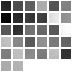

In [119]:
itorch.image(model:get(1).weight)

In [120]:
itorch.image(visLayerClone)

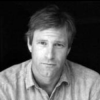

In [121]:
itorch.image(visLayer)

In [122]:
model:get(1).weight

(1,1,.,.) = 
 Columns 1 to 9
 -4.6003 -4.8159 -4.8320 -4.9150 -5.0130 -4.9607 -5.1337 -4.9971 -5.1237
 -4.7279 -4.6925 -4.8050 -4.8637 -5.0594 -5.0246 -5.1387 -5.1249 -5.1792
 -4.7086 -4.7912 -4.7974 -4.9552 -4.9062 -5.0113 -5.0953 -5.0038 -5.1344
 -4.6955 -4.6446 -4.8466 -4.7605 -4.9636 -4.9549 -4.9945 -5.0105 -5.1092
 -4.6729 -4.6976 -4.6636 -4.7824 -4.7930 -4.9738 -4.9353 -4.8717 -4.9417
 -4.5539 -4.7141 -4.7761 -4.6925 -4.8666 -4.9125 -4.9540 -4.9348 -4.9443
 -4.4550 -4.5448 -4.5662 -4.7437 -4.6737 -4.8235 -4.8969 -4.8717 -4.8660
 -4.4625 -4.5667 -4.5329 -4.5367 -4.5735 -4.6290 -4.7902 -4.7170 -4.6987
 -4.3119 -4.3211 -4.3608 -4.4374 -4.4723 -4.4827 -4.6439 -4.6395 -4.6009
 -4.2525 -4.2896 -4.3467 -4.3698 -4.4779 -4.5139 -4.4682 -4.5853 -4.4920

Columns 10 to 10
 -5.0008
 -5.0263
 -5.0995
 -5.0036
 -4.9396
 -5.0200
 -4.8506
 -4.7368
 -4.7275
 -4.6209

(2,1,.,.) = 
 Columns 1 to 9
 -2.1329 -2.1468 -2.2093 -2.2249 -2.2158 -2.1829 -2.3356 -2.2111 -2.2741
 -2.0357 -2.1506 -2.2245 -2.30

.9812 -2.0111 -2.0538 -1.9032 -1.9964 -2.0812 -2.0956 -2.0931
 -1.7843 -1.9163 -1.8953 -1.9119 -1.9929 -1.9750 -1.9835 -2.1068 -2.0307

Columns 10 to 10
 -1.9649
 -1.8653
 -1.9707
 -1.8945
 -1.8988
 -1.9737
 -2.0839
 -1.9945
 -1.9917
 -2.0396

(6,1,.,.) = 
 Columns 1 to 9
  1.2224  1.1888  1.1044  1.1233  1.0477  0.9647  0.9769  0.8730  0.8906
  1.1573  1.1625  1.1548  0.9852  0.9755  0.9387  0.9821  0.8777  0.8622
  1.1414  1.1375  1.0355  1.0571  1.0684  0.9223  0.8681  0.8255  0.8060
  1.0106  0.9967  1.0761  0.9069  1.0024  0.8707  0.9791  0.7827  0.8169
  1.0479  1.0256  0.9632  0.9579  0.8574  0.8093  0.8922  0.7812  0.8252
  1.0962  1.0508  1.0730  0.9413  1.0105  0.9863  0.7990  0.8037  0.8247
  1.0409  0.9660  0.9460  0.9395  0.9645  0.8721  0.7731  0.8233  0.8461
  1.0556  0.8951  0.9115  0.8547  0.9150  0.9608  0.8368  0.8289  0.8693
  0.9979  0.9463  1.0278  0.8185  0.8841  0.7912  0.9177  0.8219  0.8192
  0.9342  0.9847  0.8392  0.9805  0.9774  0.8918  0.8928  0.8807  0.86

3.4563 -3.4887
 -3.0006 -3.0327 -3.1713 -3.1072 -3.3285 -3.3407 -3.4216 -3.5121 -3.5583
 -2.9431 -2.9869 -3.2157 -3.2090 -3.3739 -3.3435 -3.4801 -3.5254 -3.4928
 -3.0022 -3.1583 -3.1937 -3.2021 -3.3040 -3.3270 -3.5128 -3.4272 -3.5628
 -2.9390 -3.0973 -3.2276 -3.2966 -3.3924 -3.3892 -3.3830 -3.5434 -3.5485
 -2.9967 -3.0689 -3.2396 -3.2334 -3.3031 -3.3450 -3.3492 -3.4003 -3.4474

Columns 10 to 10
 -3.2176
 -3.3919
 -3.4354
 -3.5058
 -3.5325
 -3.4279
 -3.5326
 -3.4803
 -3.4816
 -3.5389

(11,1,.,.) = 
 Columns 1 to 9
  6.6109  6.6629  6.8061  6.8194  6.9453  7.1743  7.2145  7.2313  7.3170
  6.6616  6.7045  6.7699  7.0179  7.0756  7.0930  7.2703  7.3841  7.3891
  6.5879  6.6327  6.7416  6.8717  7.0008  7.0774  7.1746  7.3432  7.3489
  6.5655  6.6288  6.7473  6.8566  7.0193  7.1578  7.1609  7.2490  7.2950
  6.7140  6.7115  6.8602  6.9830  6.9893  7.1122  7.3241  7.2723  7.3955
  6.7094  6.8421  6.8245  6.9412  7.1233  7.2456  7.3284  7.3336  7.3363
  6.7588  6.8368  6.9993  7.0330  7.0104  7

2438 -0.1524 -0.1463 -0.0700 -0.0427 -0.1629
 -0.2786 -0.3793 -0.3140 -0.2201 -0.1784 -0.1415 -0.0505 -0.1345  0.0256
 -0.2230 -0.1705 -0.2034 -0.0819 -0.1074 -0.0323 -0.0903 -0.1258  0.0765
 -0.1917 -0.2890 -0.2375 -0.1761 -0.1321  0.0278  0.0713  0.0927  0.0315
 -0.1525 -0.0807 -0.2009  0.0250 -0.1005  0.0672  0.0986 -0.0533 -0.0262
 -0.1253 -0.0596 -0.1481 -0.0926 -0.0112  0.0435  0.0940 -0.0010  0.1399
 -0.1458 -0.0887 -0.1000 -0.0615  0.0037  0.0768  0.1651  0.0835  0.0141
 -0.1697 -0.1332 -0.0489 -0.0115  0.1180  0.0550  0.1337  0.0779  0.0595
 -0.0726 -0.0569  0.0405 -0.0462  0.1098  0.0669  0.1655  0.0337  0.0509

Columns 10 to 10
 -0.0854
 -0.1567
 -0.0743
 -0.0525
  0.0878
  0.0810
  0.1254
  0.1754
  0.1949
  0.2000

(16,1,.,.) = 
 Columns 1 to 9
 -0.4278 -0.5227 -0.5090 -0.4569 -0.4736 -0.5805 -0.4627 -0.4658 -0.5666
 -0.5167 -0.4374 -0.4722 -0.4831 -0.6000 -0.5688 -0.6034 -0.4883 -0.5248
 -0.5238 -0.4883 -0.5131 -0.6437 -0.5652 -0.6650 -0.5729 -0.6542 -0.4536
 -0.5280 -0.5

  4.8720

Columns 10 to 10
  4.9562
  4.9665
  4.9526
  4.8862
  5.0530
  4.9526
  5.0249
  4.9161
  4.9795
  4.9538

(20,1,.,.) = 
 Columns 1 to 9
  1.4320  1.4337  1.4849  1.3588  1.4552  1.4578  1.3342  1.3804  1.3242
  1.3967  1.4765  1.4321  1.4846  1.3810  1.4371  1.3569  1.4798  1.3715
  1.3979  1.4155  1.5180  1.4242  1.4795  1.4270  1.4404  1.3042  1.4557
  1.3877  1.3814  1.4336  1.4218  1.3819  1.4739  1.4228  1.3751  1.2925
  1.3880  1.4726  1.3712  1.3433  1.3704  1.3199  1.4595  1.3372  1.3462
  1.4354  1.4975  1.4632  1.3784  1.3930  1.3484  1.2682  1.2280  1.3575
  1.4471  1.3700  1.4017  1.3872  1.3096  1.3045  1.3115  1.3791  1.1962
  1.3597  1.3159  1.3983  1.3417  1.2067  1.2325  1.3131  1.2560  1.2660
  1.3575  1.3323  1.2061  1.3346  1.1718  1.1768  1.2162  1.1469  1.1583
  1.3475  1.2194  1.2900  1.2539  1.1510  1.2474  1.1400  1.2568  1.2477

Columns 10 to 10
  1.3906
  1.4423
  1.3130
  1.4294
  1.3388
  1.2365
  1.3273
  1.2119
  1.1026
  1.1429

(21,1,.,.) = 

0.8860 -0.9072 -1.0379 -1.0411 -1.0952
 -0.8355 -0.7393 -0.8175 -0.7414 -0.8235 -0.8808 -0.8526 -0.9226 -1.0387
 -0.6541 -0.6510 -0.8211 -0.8123 -0.7073 -0.7530 -0.9233 -0.8944 -0.8102
 -0.6412 -0.7752 -0.7263 -0.7577 -0.7801 -0.9184 -0.9408 -0.7887 -0.8873

Columns 10 to 10
 -1.3345
 -1.1423
 -1.2833
 -1.0882
 -1.0378
 -0.9819
 -1.0126
 -1.0751
 -0.8334
 -0.8161

(25,1,.,.) = 
 Columns 1 to 9
  0.7736  0.6882  0.7970  0.8106  0.6489  0.7676  0.6462  0.7289  0.7809
  0.8209  0.7792  0.7311  0.6890  0.7616  0.6183  0.7431  0.6217  0.6941
  0.7466  0.6833  0.6622  0.8002  0.6538  0.7586  0.6366  0.6044  0.6159
  0.7791  0.7975  0.7851  0.7836  0.6882  0.7423  0.6140  0.5601  0.6743
  0.7408  0.7435  0.6863  0.7717  0.5688  0.6882  0.7224  0.5720  0.5923
  0.8198  0.7584  0.6238  0.6998  0.7106  0.7331  0.6572  0.6676  0.6131
  0.6842  0.6695  0.6344  0.7326  0.6539  0.6111  0.6112  0.6951  0.7230
  0.7524  0.6290  0.7060  0.5840  0.6381  0.5545  0.6951  0.6331  0.7025
  0.7846  0.7824  0

6827  4.8119  4.6897  4.7138  4.8506  4.7487  4.9213  4.8781  5.0013
  4.7763  4.7446  4.6520  4.7146  4.8239  4.8240  4.8076  4.7495  4.8138
  4.7263  4.7551  4.6983  4.6869  4.6642  4.7243  4.7700  4.9067  4.7530
  4.5956  4.7260  4.6573  4.7338  4.7941  4.7033  4.8148  4.8109  4.7411
  4.5421  4.4809  4.5657  4.5202  4.6715  4.6985  4.6851  4.6845  4.6806
  4.5097  4.3994  4.4907  4.4966  4.5919  4.4706  4.5456  4.5136  4.4899
  4.5218  4.3753  4.3946  4.4424  4.4496  4.5058  4.6074  4.5837  4.4992

Columns 10 to 10
  5.1373
  5.0244
  5.0785
  4.8871
  4.8310
  4.8564
  4.7462
  4.6663
  4.5277
  4.6203

(30,1,.,.) = 
 Columns 1 to 9
 -3.8787 -3.9207 -3.9137 -4.0308 -4.0700 -4.0489 -4.1066 -4.2048 -4.1485
 -3.8530 -4.0356 -3.9746 -3.9677 -4.0592 -4.0665 -4.1308 -4.0471 -4.1017
 -3.9076 -4.0185 -3.9079 -4.0804 -3.9353 -3.9456 -4.0606 -4.1479 -4.1154
 -3.8481 -3.9890 -3.9066 -4.0439 -4.0257 -3.9142 -4.1102 -3.9439 -3.9580
 -3.8330 -3.9675 -3.8900 -3.9819 -3.9282 -3.9356 -3.9345 -3.98